## Current status
- The current goal is to make standard QAOA work with adiabatic-like trajectories.
- L-BFGS-B optimizer (bounded) needs a lot of layers to find the factorization solution. From $p \sim 40$ layers, the
angle trajectories stops being quasi-adiabatic: some oscillations and sudden drops appear for $\gamma$.
- BFGS (unbounded) finds the solution with fidelity $1$ using only $p \sim 30$ layers. For L-BFGS-B, we need more than
$100$ layers to achieve comparable results. BFGS doesn't reflect any similarity to adiabaticity.

### Things I've tried
- Multiple definitions for max_gamma ($\gamma \in [0, \text{max\_gamma}]$): using maximum E, norm of E, two or three times the original definition, etc.
- Multiple allowed intervals for $\beta$: $[0, \pi],~[0, 2\pi],~[0, \pi/2],~[-\pi/4, \pi/4],~\dots$
- Multiple optimizers: BFGS, L-BFGS-B, COBYLA, Nelder-Mead
- Multiple optimizer options: tolerances, maximum iterations, etc.
- Rescaling Hamiltonians: max_E $\rightarrow$ 1

### Things I've checked
- Cost Hamiltonians are defined correctly, encoding the solution in the ground state.
- For $p=1$ layer, multiple initializations converge to the same optimal point. The cost function only has one minimum
in the main branch for $\gamma$ and $\beta$.
- Gradients are computed correctly, double checked against the energy profile.
- Interpolation is computed correctly.

### Doubts
- I understand that it's been observed that optimal QAOA trajectories tend to mimic adiabatic passages for MaxCut and
QUBO problems. Is our problem really a QUBO problem?
- Should the trajectories be perfectly adiabatic or some oscillations are accepted?
- With current results (BFGS), can we draw any conclusions concerning adiabatic factorization?

### Next steps
- Explore adiabaticity in our method. Linear hamiltonian. N=39
- Try boundary approach with our method. N=39
- Explore N=51 or N=77.
- Prepare presentation with results: boundary vs best for standard, bounded (start with +-+-+) vs unbounded for linear (¿adiabatic?)

https://arxiv.org/pdf/2309.15162

## Preprocessing

In [18]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display, Markdown, Latex

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)
experiment_results['cost'] = experiment_results.apply(lambda row: row['cost']**2 if row['cost_hamiltonian']=='abs_H' else row['cost'], axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [20]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [21]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Preliminar analysis

### One Layer

0.18479956785822313


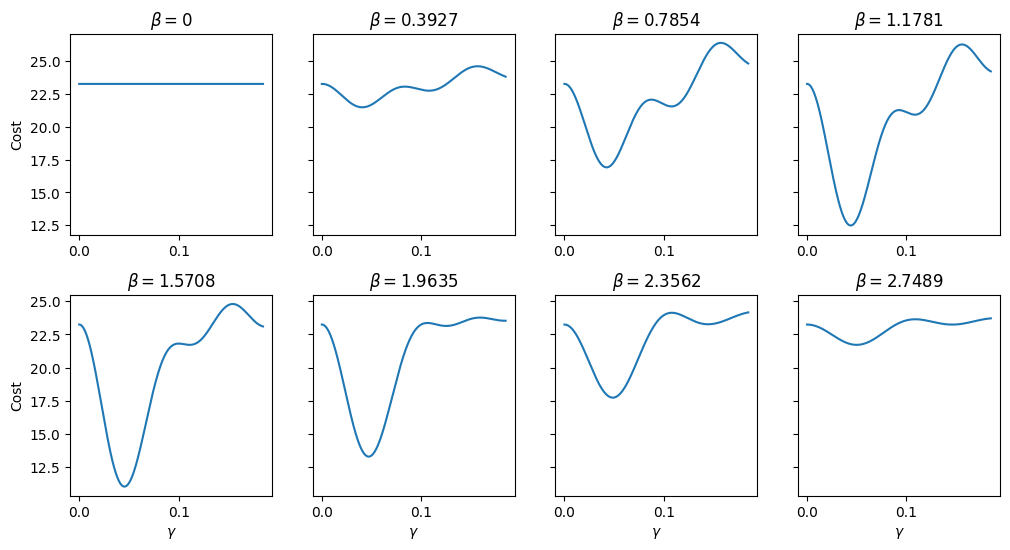

In [2]:
solver = QAOASolver(35, problem_hamiltonian='linear_H', cost_hamiltonian='abs_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

### Two Layers

0.0014424208694168012


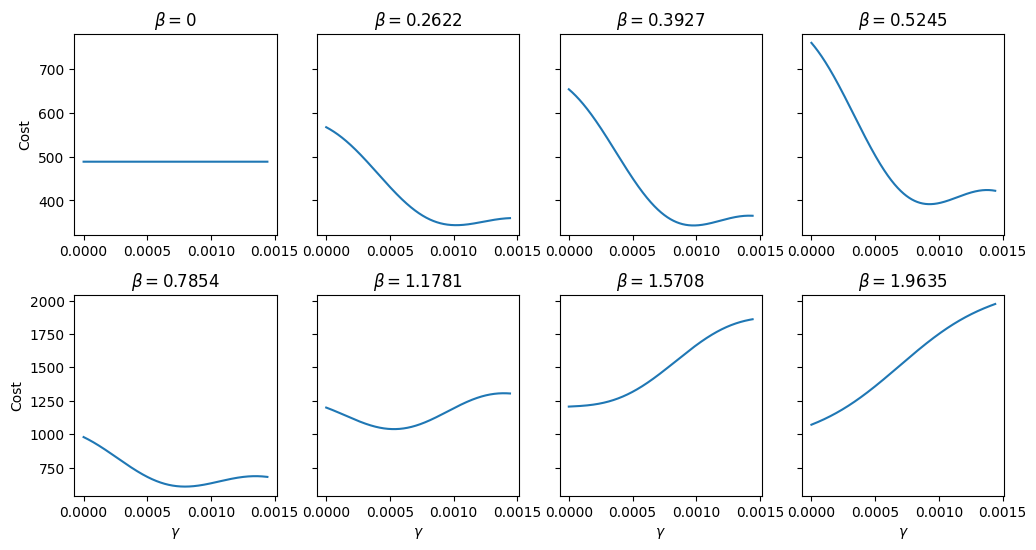

In [11]:
solver = QAOASolver(39, problem_hamiltonian='quadratic_H', cost_hamiltonian='quadratic_H')

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

# Optimal angles for p=1
gamma_0 = 0.0004457756607718827
beta_0 = 0.5244786704891575

# Exploring angles for p=2
gammas = np.linspace(0, max_gamma, 10000)
betas = [0, beta_0/2, np.pi/8, beta_0, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey='row', sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma_0, gamma, beta_0, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

### Experiment revision

In [12]:
experiment = 'N39_linear_quadratic_20250804124024756880'
p = 10
N = int(experiment.split('_')[0].removeprefix('N'))
setup = '_'.join(experiment.split('_')[1:-1])
solver = QAOASolver(
    N,
    problem_hamiltonian='quadratic_H' if setup=='standard' else 'linear_H',
    cost_hamiltonian='abs_H' if setup=='linear_abs' else 'quadratic_H'
)


df = pd.read_json(f'experiments/results/N{N}_{setup}/{experiment}.jsonl', lines=True)
df_layer = df[df['layers']==p].reset_index()
gammas_0 = df_layer.loc[0,'gammas']
betas_0 = df_layer.loc[0,'betas']

min_cost=56.155718326111376, opt_gamma=1.4035, opt_beta=0.01


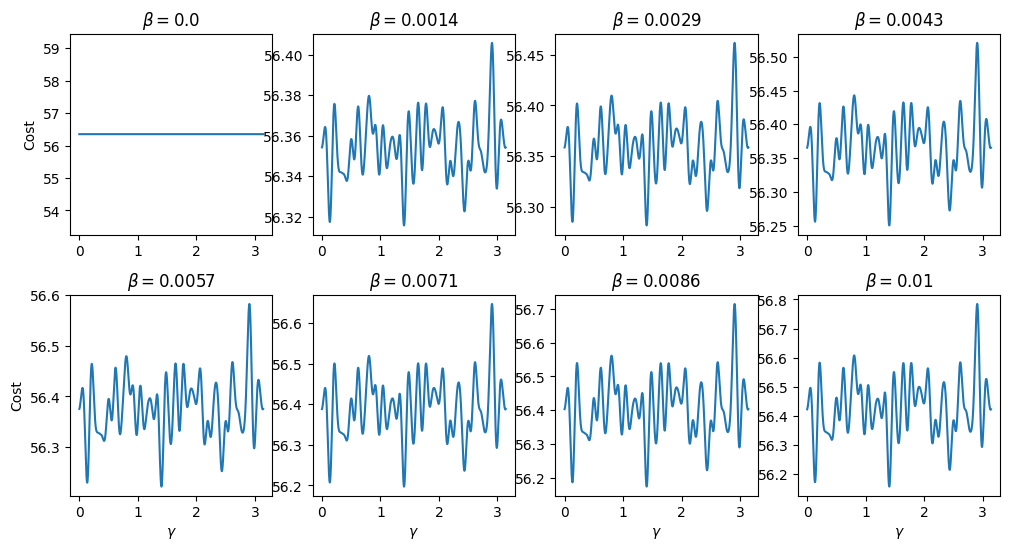

In [13]:
# Exploring angles for p+1 layers
gammas = np.linspace(0, np.pi, 10000)
betas = np.linspace(0, 0.01, 8)

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey=False, sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

min_cost = 100
opt_gamma = 0
obt_beta = 0
for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost(gammas_0 + [gamma] + betas_0 + [beta])
        cost.append(res)

        if res < min_cost:
            min_cost = res
            opt_gamma = gamma
            opt_beta = beta

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})
    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

print(f'min_cost={min_cost}, opt_gamma={round(opt_gamma, 4)}, opt_beta={round(opt_beta, 4)}')

## Standard protocol

### N = 15

## N=15

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1470  15      BFGS       1    0.015     1.1  [0.013711376820269001]   
1460  15  L-BFGS-B       1    0.015     1.1  [0.013711376795744001]   

                     betas       cost  fidelity  
1470  [0.9967390569101721]  36.076613  0.270584  
1460  [0.9967390584132101]  36.076613  0.270584

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1479  15      BFGS      10    0.015     1.1  7.383221e-22       1.0
1469  15  L-BFGS-B      10    0.015     1.1  2.029999e-10       1.0

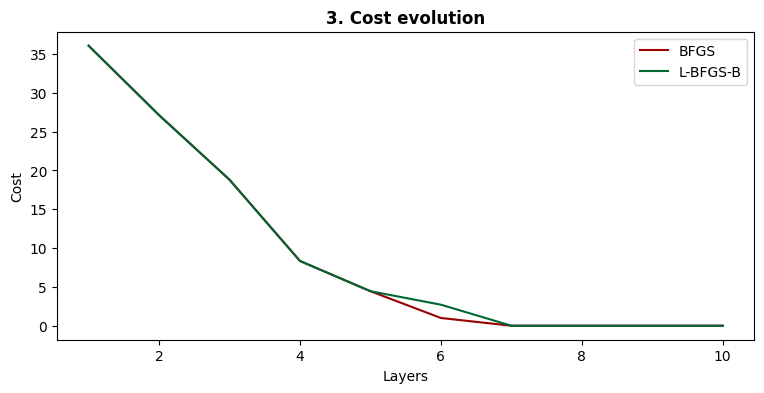

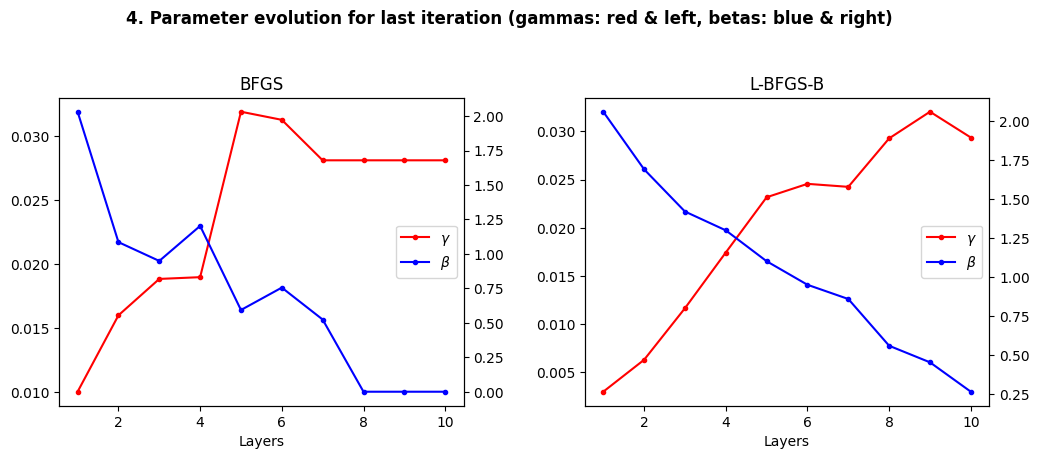

In [57]:
N = 15

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
10  21      BFGS       1    0.007     1.5  [0.008278311895312]   
0   21  L-BFGS-B       1    0.007     1.5  [0.008278311895116]   

                  betas       cost  fidelity  
10  [1.529769538903815]  32.774907  0.757476  
0   [1.529769538820518]  32.774907  0.757476

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
19  21      BFGS      10    0.007     1.5  1.346965e-21       1.0
9   21  L-BFGS-B      10    0.007     1.5  2.852285e-09       1.0

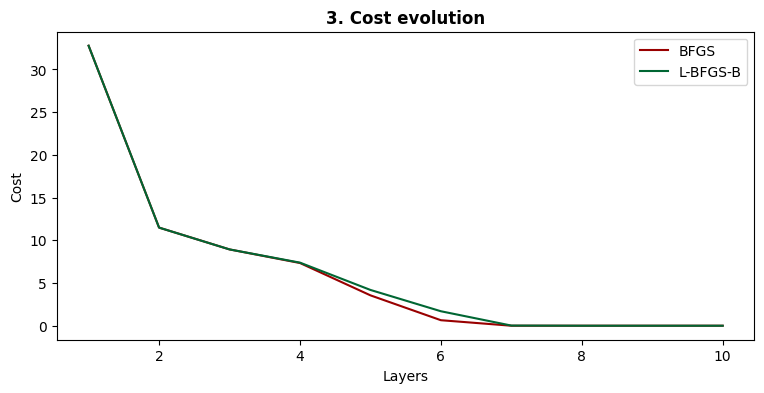

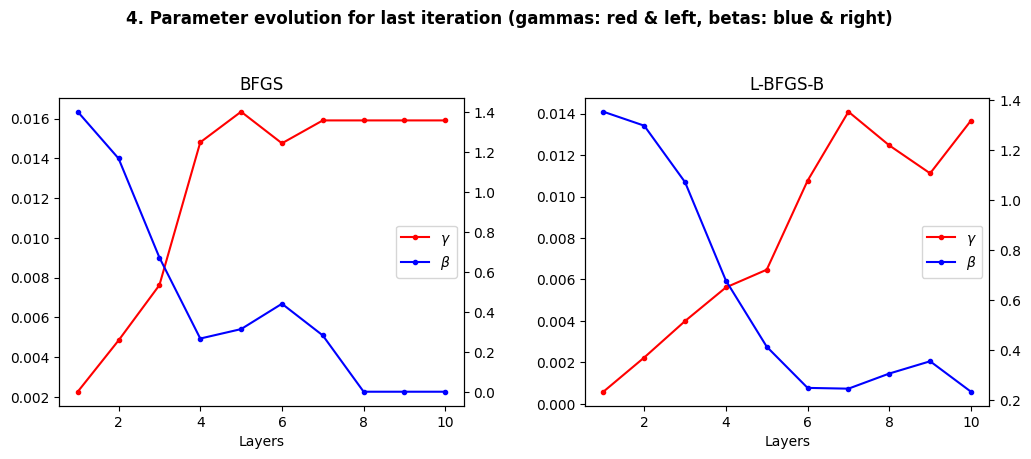

In [58]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 35

## N=35

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                    gammas  \
1570  35      BFGS       1   0.0005     0.4       [0.000382090097321]   
1540  35  L-BFGS-B       1   0.0005     0.4  [0.00038209008785900005]   

                     betas        cost  fidelity  
1570  [0.5448596616379281]  434.040464  0.090441  
1540  [0.5448596676230331]  434.040464  0.090440

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1599  35      BFGS      30   0.0005     0.4   0.582317  0.864901
1569  35  L-BFGS-B      30   0.0005     0.4  15.324603  0.429884

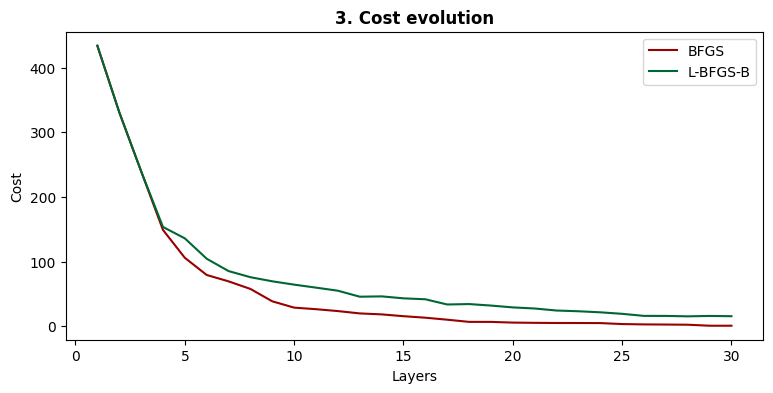

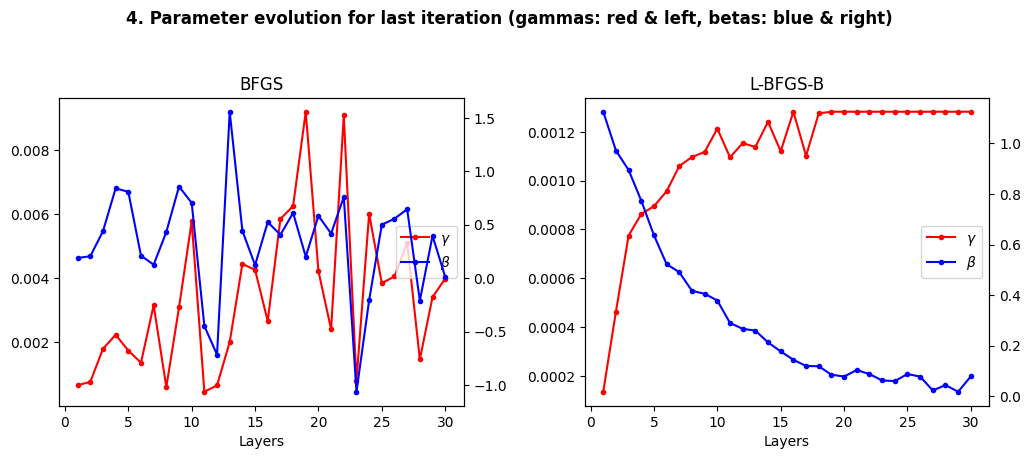

In [59]:
N = 35

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                    gammas  \
140  39      BFGS       1   0.0005     0.4       [0.000445775660771]   
170  39  L-BFGS-B       1   0.0005     0.4  [0.00044577565735500006]   

                    betas        cost  fidelity  
140  [0.5244786704891571]  488.233997  0.045932  
170   [0.524478674085292]  488.233997  0.045932

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
169  39      BFGS      30   0.0005     0.4   0.444525  0.982655
199  39  L-BFGS-B      30   0.0005     0.4  16.934879  0.338605

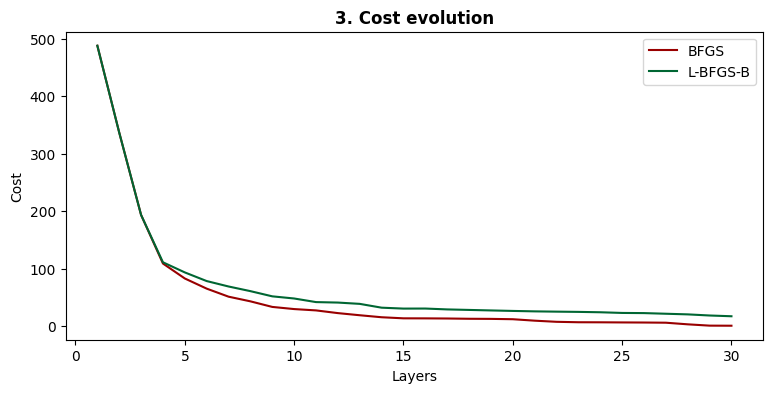

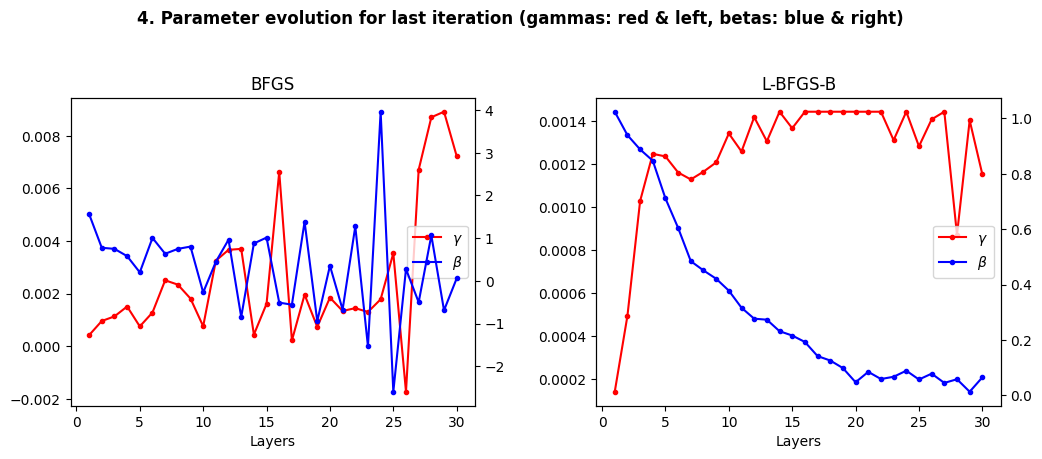

In [60]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                   gammas  \
610  51      BFGS       1   0.0001     0.8  [7.653187295904522e-05]   
560  51  L-BFGS-B       1   0.0001     0.8    [7.6531872913161e-05]   

                    betas         cost  fidelity  
610  [0.6251993693818071]  1326.671435   0.02383  
560   [0.625199370602673]  1326.671435   0.02383

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
659  51      BFGS      50   0.0001     0.8  14.969879  0.244035
609  51  L-BFGS-B      50   0.0001     0.8  76.780489  0.155842

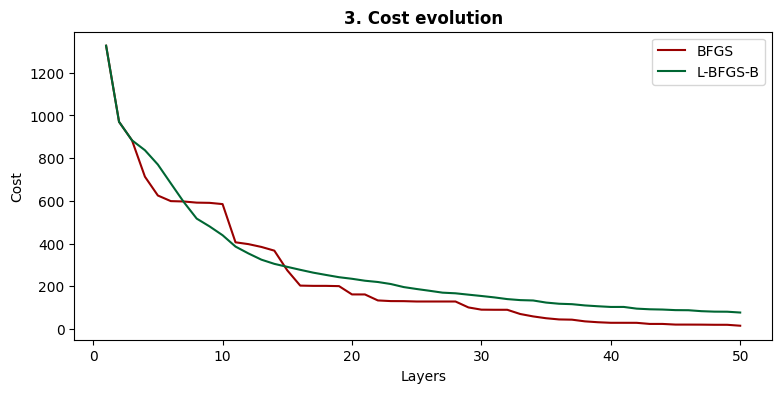

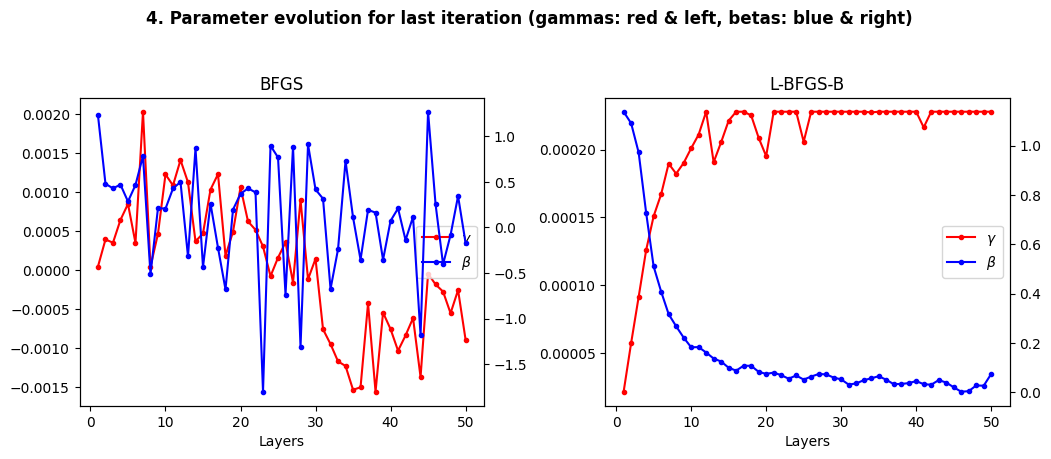

In [61]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
1150  77      BFGS       1   0.0001    0.39  [0.000108307745618]   
1100  77  L-BFGS-B       1   0.0001    0.39  [0.000108307745781]   

                     betas         cost  fidelity  
1150  [0.5230479893037681]  1934.541313  0.022078  
1100   [0.523047988282447]  1934.541313  0.022078

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1199  77      BFGS      50   0.0001    0.39  10.891139  0.399982
1149  77  L-BFGS-B      50   0.0001    0.39  56.238237  0.138790

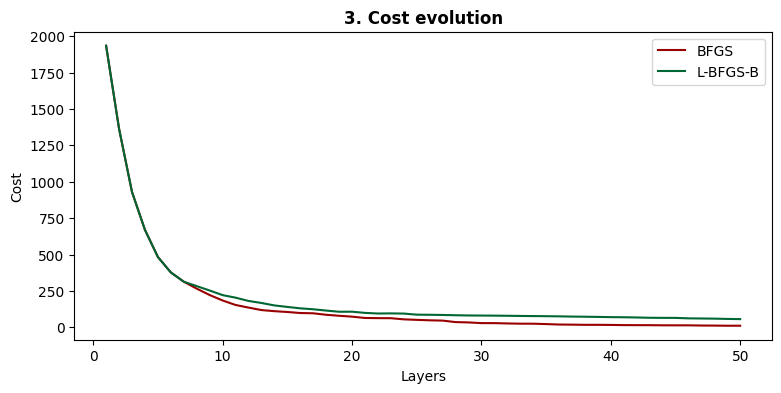

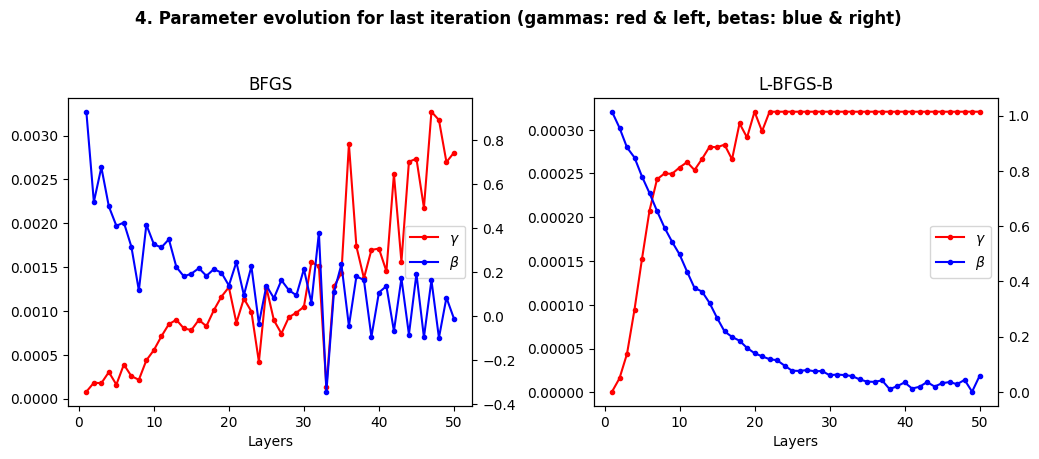

In [62]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                    gammas  \
1360  87      BFGS       1  0.00002     0.8  [1.7797972544527962e-05]   
1410  87  L-BFGS-B       1  0.00002     0.8    [1.77979722152876e-05]   

                     betas         cost  fidelity  
1360    [0.64937828388257]  5104.575317  0.009896  
1410  [0.6493783361282911]  5104.575317  0.009896

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
1409  87      BFGS      50  0.00002     0.8  190.280669  0.061161
1459  87  L-BFGS-B      50  0.00002     0.8  263.635548  0.044348

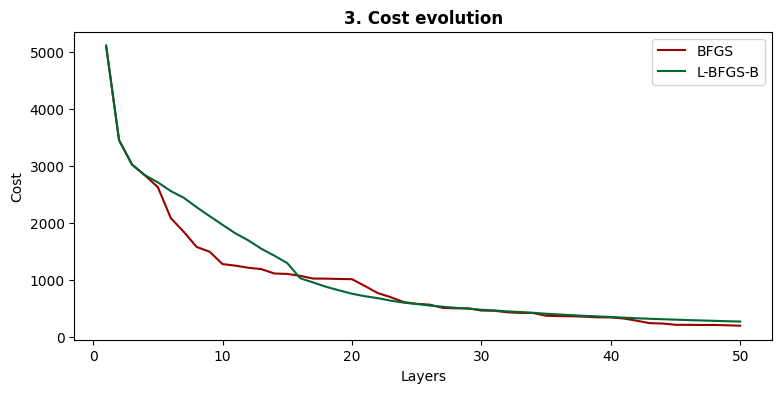

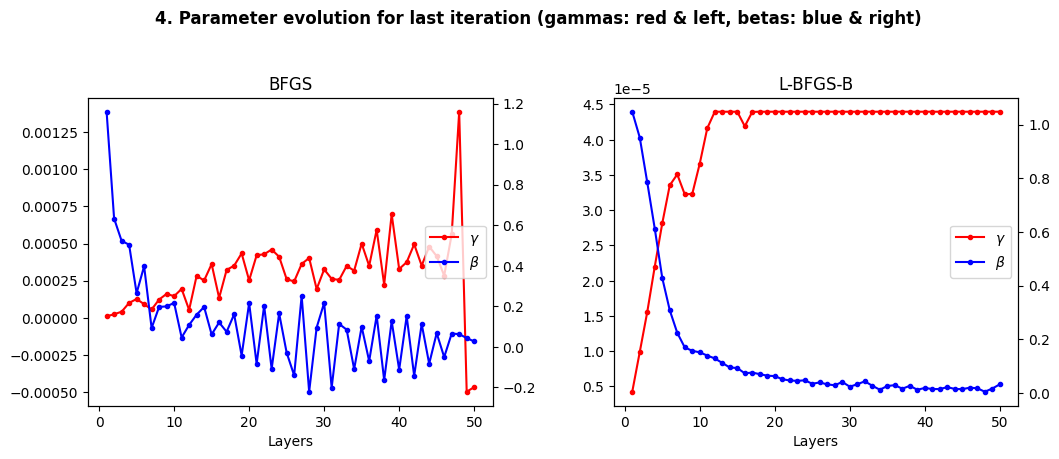

In [63]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                   gammas  \
460  95      BFGS       1  0.00002     0.8  [1.826878524076459e-05]   
510  95  L-BFGS-B       1  0.00002     0.8  [1.826878518334806e-05]   

                    betas         cost  fidelity  
460  [0.6286191475733971]  5273.884037  0.011792  
510   [0.628619146302954]  5273.884037  0.011792

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
509  95      BFGS      50  0.00002     0.8  117.443747  0.081479
559  95  L-BFGS-B      50  0.00002     0.8  278.078724  0.047123

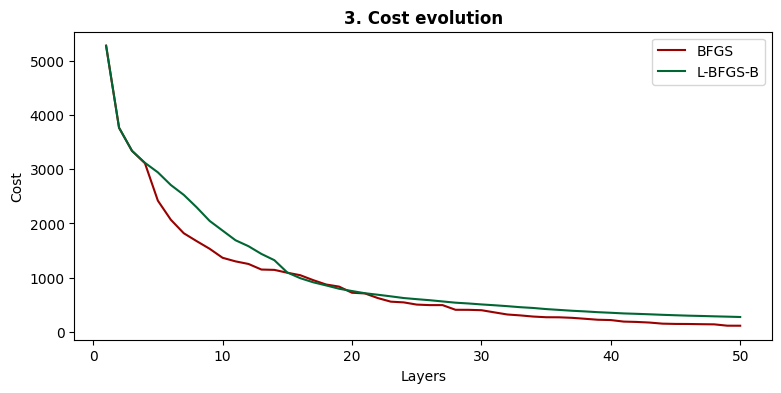

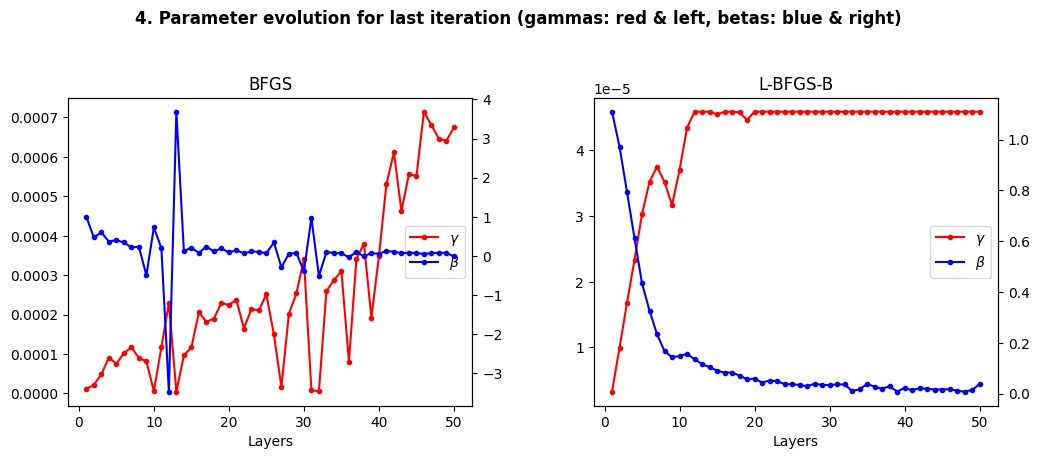

In [64]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-quadratic protocol

### N = 15

## N=15

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
1600  15      BFGS       1      0.2     1.5  [0.159408951314945]   
1610  15  L-BFGS-B       1      0.2     1.5   [0.15940895131932]   

                    betas       cost  fidelity  
1600  [1.522230797693787]  28.466086  0.680663  
1610  [1.522230797711818]  28.466086  0.680663

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1609  15      BFGS      10      0.2     1.5  1.369380e-19  1.000000
1619  15  L-BFGS-B      10      0.2     1.5  1.451259e+00  0.979841

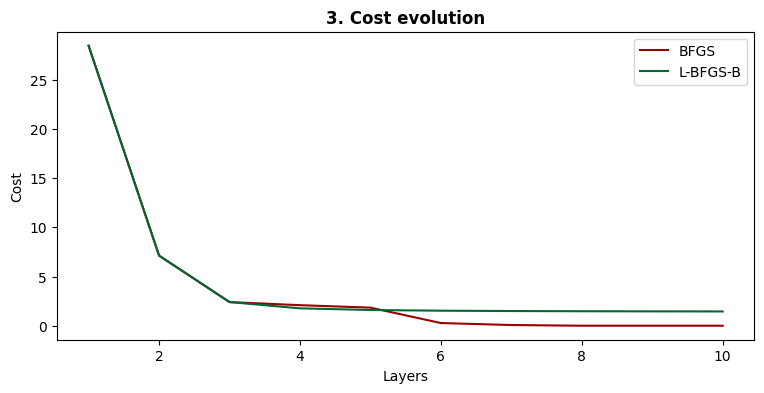

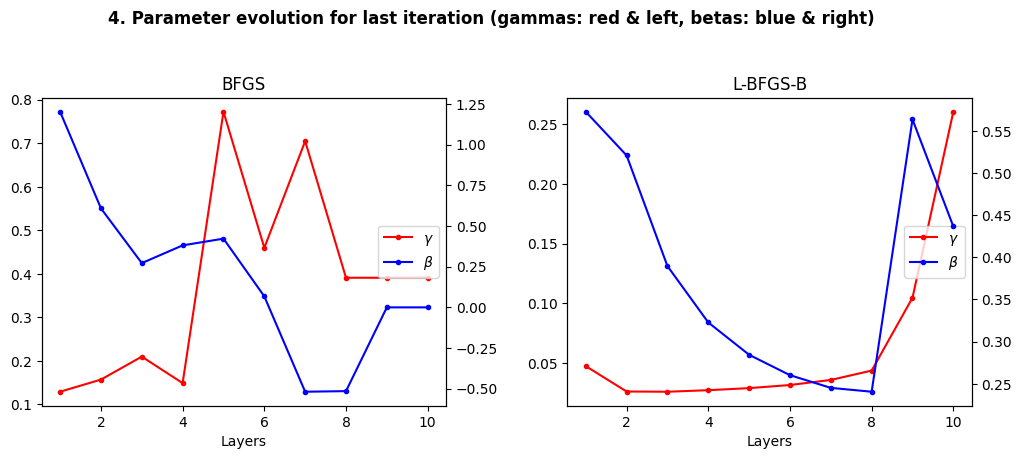

In [65]:
N = 15

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                 gammas  \
770  21      BFGS       1     0.15     1.5    [0.154564850965925]   
760  21  L-BFGS-B       1     0.15     1.5  [0.15456485072714302]   

                    betas       cost  fidelity  
770  [1.5075920586575662]  74.357584  0.169938  
760   [1.507592055147221]  74.357584  0.169938

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
779  21      BFGS      10     0.15     1.5  1.943862e-19  1.000000
769  21  L-BFGS-B      10     0.15     1.5  3.862211e+01  0.130203

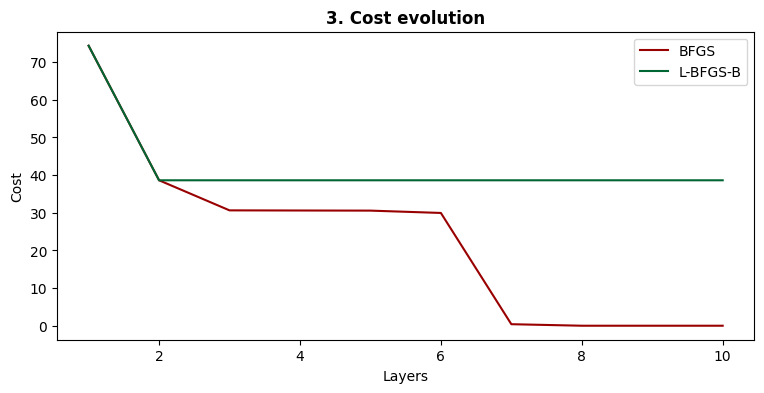

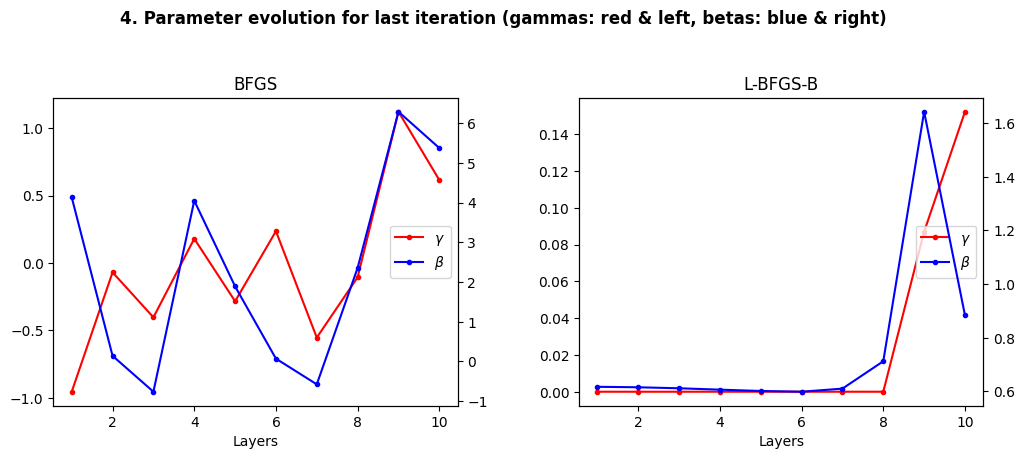

In [66]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 35

## N=35

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1200  35      BFGS       1     0.05     1.5     [0.042399206142629]   
1230  35  L-BFGS-B       1     0.05     1.5  [0.042399205205538006]   

                     betas        cost  fidelity  
1200  [1.4729811166832851]  249.277988   0.01021  
1230  [1.4729811391549261]  249.277988   0.01021

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1229  35      BFGS      30     0.05     1.5   0.146709  0.968217
1259  35  L-BFGS-B      30     0.05     1.5  76.113857  0.001979

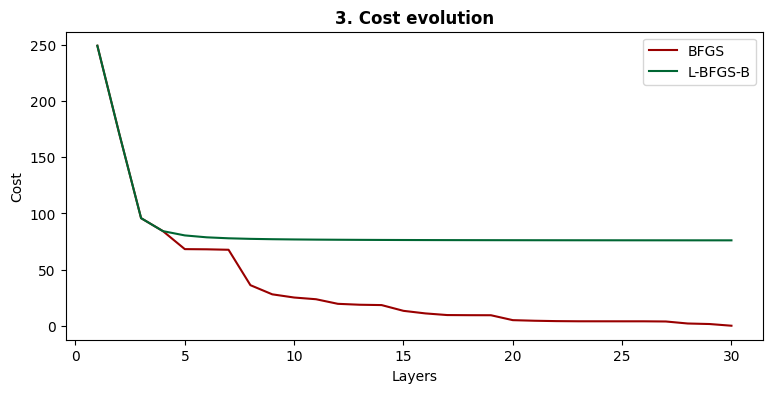

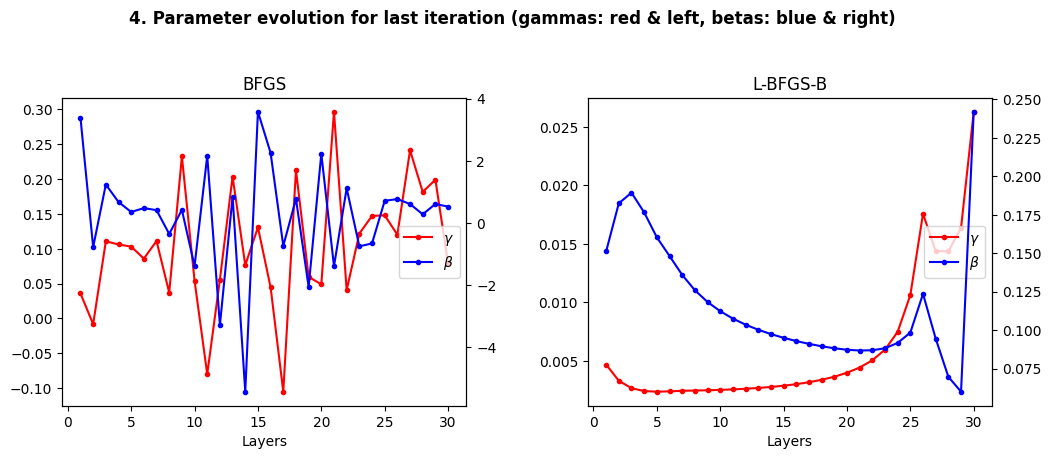

In [67]:
N = 35

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
200  39      BFGS       1     0.05     1.5  [0.042419916569209]   
230  39  L-BFGS-B       1     0.05     1.5  [0.042419916719614]   

                   betas        cost  fidelity  
200   [1.46558428370015]  308.614459  0.046635  
230  [1.465584281583984]  308.614459  0.046635

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
229  39      BFGS      30     0.05     1.5    0.004596  0.999791
259  39  L-BFGS-B      30     0.05     1.5  129.967519  0.016010

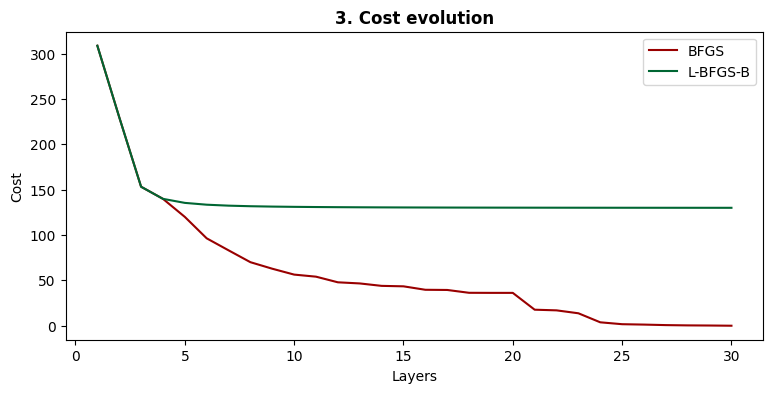

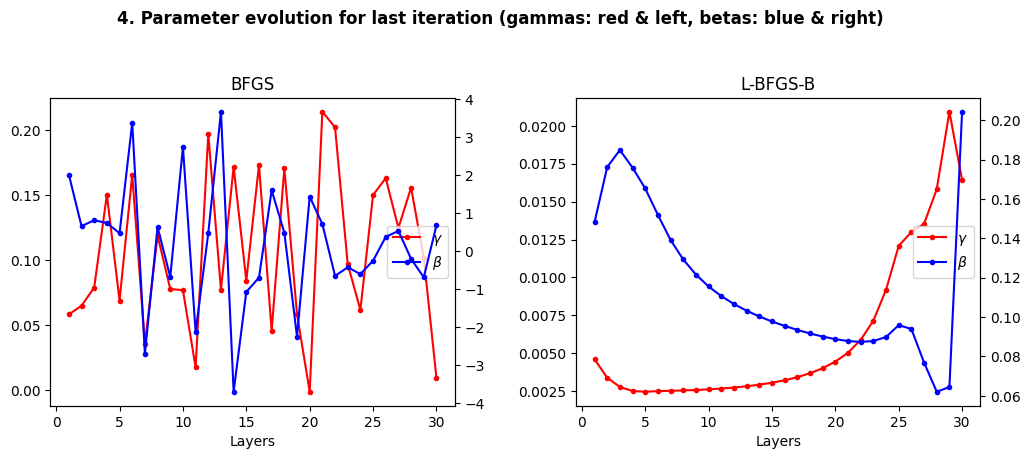

In [68]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
800  51      BFGS       1     0.01     1.1  [0.013172117193072002]   
850  51  L-BFGS-B       1     0.01     1.1  [0.013172117123907002]   

                   betas        cost  fidelity  
800  [1.071317677840412]  957.604456  0.012695  
850  [1.071317614553077]  957.604456  0.012695

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
849  51      BFGS      50     0.01     1.1   6.510248  0.008734
899  51  L-BFGS-B      50     0.01     1.1  66.013635  0.342925

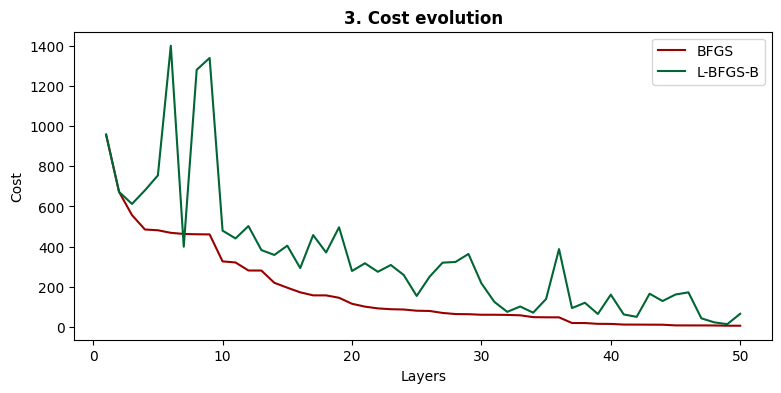

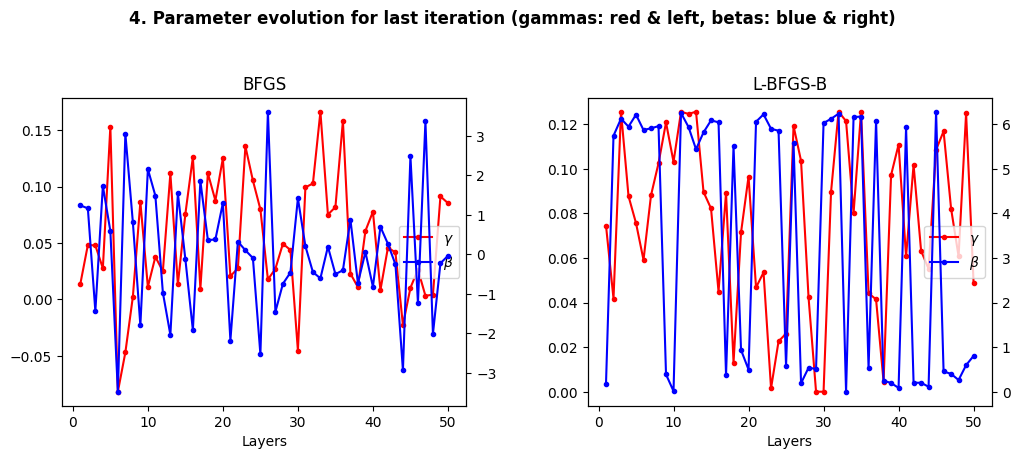

In [69]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
360  77      BFGS       1     0.05     2.3  [0.049794543256928]   
410  77  L-BFGS-B       1     0.05     2.3   [0.04979454330117]   

                   betas         cost  fidelity  
360  [2.270977840921084]  1382.099774  0.104663  
410  [2.270977842258782]  1382.099774  0.104663

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
409  77      BFGS      50     0.05     2.3    1.364976  0.934051
459  77  L-BFGS-B      50     0.05     2.3  194.919376  0.322893

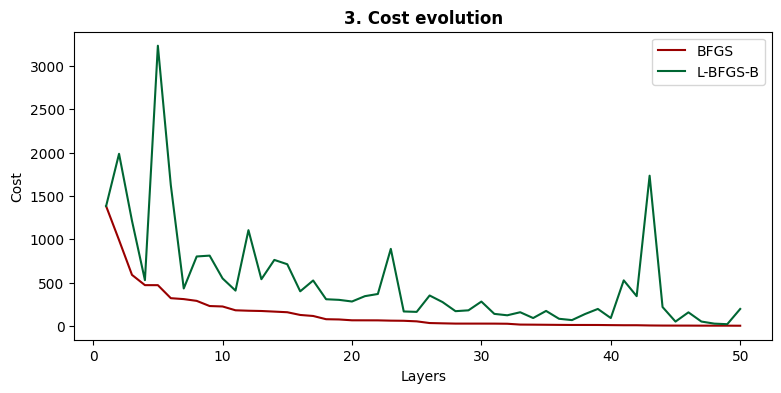

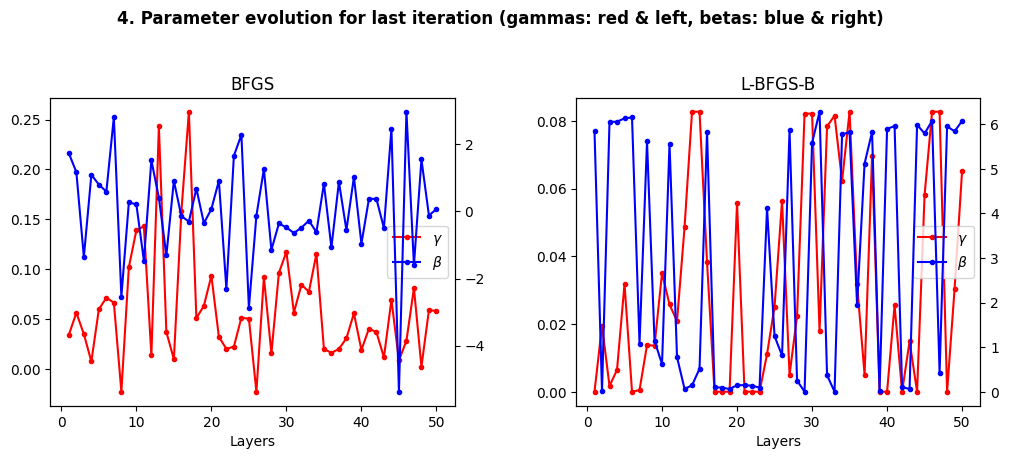

In [70]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
310  87      BFGS       1     0.02     0.8  [0.021105579454695003]   
260  87  L-BFGS-B       1     0.02     0.8  [0.021105579455356002]   

                    betas         cost  fidelity  
310   [0.846775704930748]  4595.785424  0.029289  
260  [0.8467757047550181]  4595.785424  0.029289

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
359  87      BFGS      50     0.02     0.8  157.346934  0.409059
309  87  L-BFGS-B      50     0.02     0.8  116.587148  0.786320

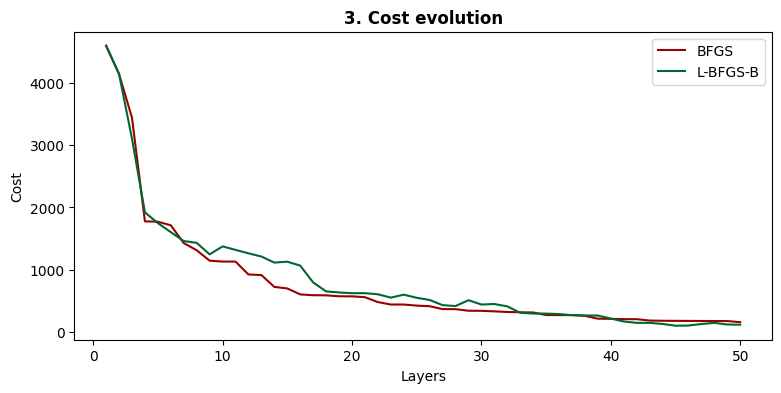

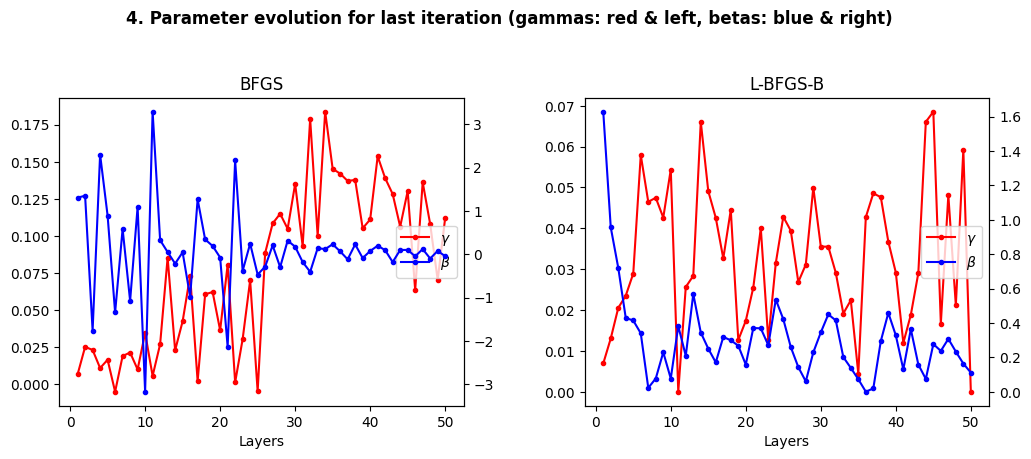

In [71]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1310  95      BFGS       1  0.00002     0.8  [-0.38102473977994206]   
1260  95  L-BFGS-B       1  0.00002     0.8                   [0.0]   

                     betas          cost  fidelity  
1310  [1.6566699747106721]   5862.389439  0.017003  
1260                 [0.0]  13690.000000  0.007812

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1359  95      BFGS      50  0.00002     0.8    283.906942  0.027451
1309  95  L-BFGS-B      50  0.00002     0.8  13690.000000  0.007812

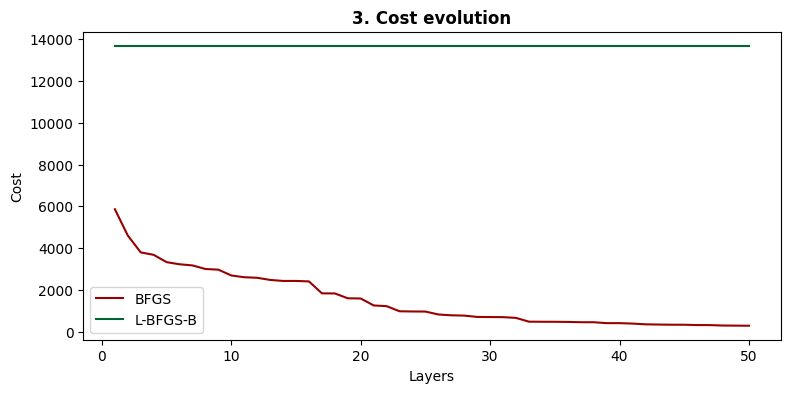

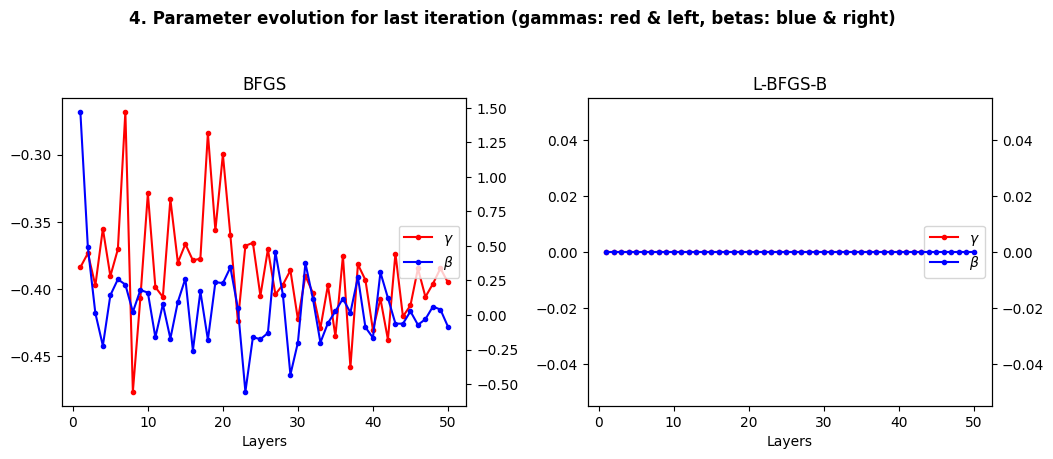

In [72]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_quadratic')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Linear-abs protocol

### N = 15

## N=15

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                 gammas  \
20  15      BFGS       1      0.2     1.5    [0.171883162676973]   
30  15  L-BFGS-B       1      0.2     1.5  [0.17188316503741802]   

                  betas      cost  fidelity  
20  [1.493692681226321]  7.601148  0.698358  
30  [1.493692670870437]  7.601148  0.698358

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
29  15      BFGS      10      0.2     1.5  9.991952e-34  1.000000
39  15  L-BFGS-B      10      0.2     1.5  2.648444e-02  0.981323

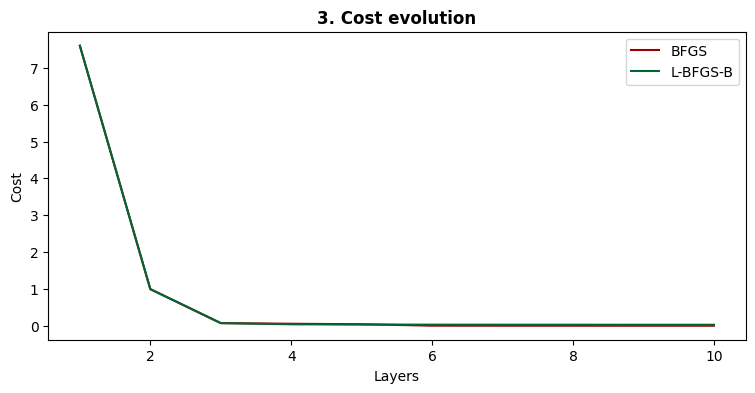

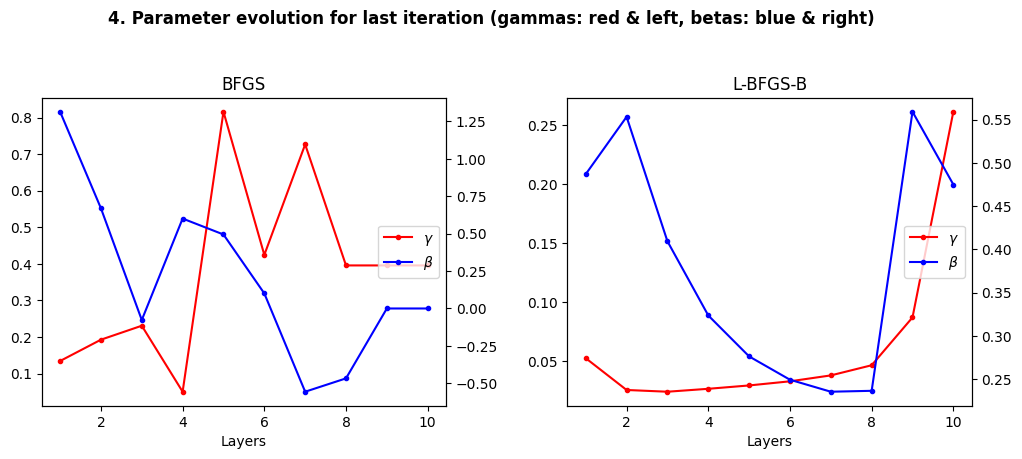

In [73]:
N = 15

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 21

## N=21

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
790  21      BFGS       1     0.15     1.5  [0.150167535914248]   
780  21  L-BFGS-B       1     0.15     1.5  [0.150167529669819]   

                    betas       cost  fidelity  
790  [1.4849625382688751]  46.362263  0.174848  
780   [1.484962492110762]  46.362263  0.174848

**2. State at layers=10**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
799  21      BFGS      10     0.15     1.5  2.466064e-34  1.000000
789  21  L-BFGS-B      10     0.15     1.5  3.052441e+01  0.149457

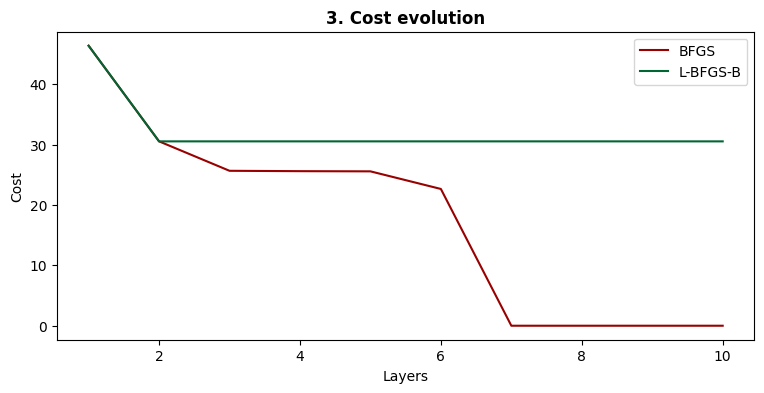

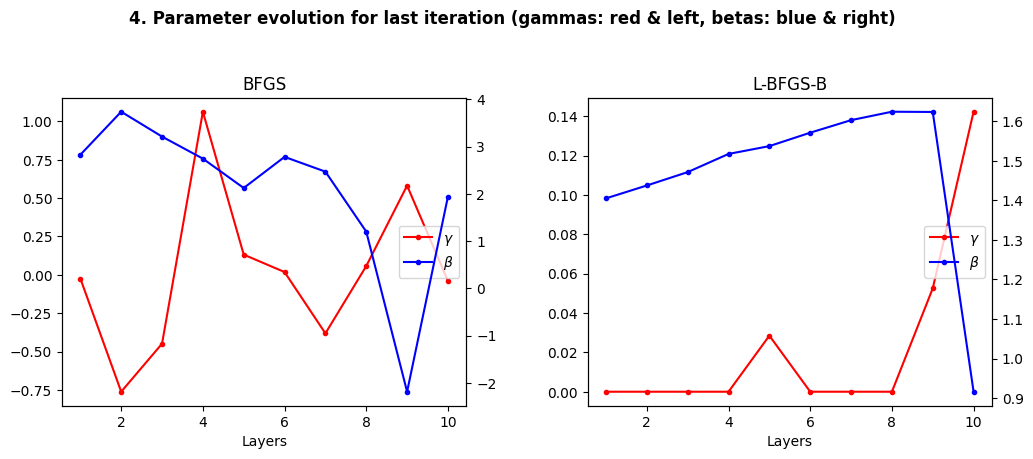

In [74]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 35

## N=35

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1650  35      BFGS       1     0.05     1.5  [0.045298379469774004]   
1620  35  L-BFGS-B       1     0.05     1.5   [0.04529837946071601]   

                    betas      cost  fidelity  
1650  [1.524556966516059]  120.5942    0.0103  
1620  [1.524556966555093]  120.5942    0.0103

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0       cost  fidelity
1679  35      BFGS      30     0.05     1.5   0.000285  0.996695
1649  35  L-BFGS-B      30     0.05     1.5  36.126173  0.001908

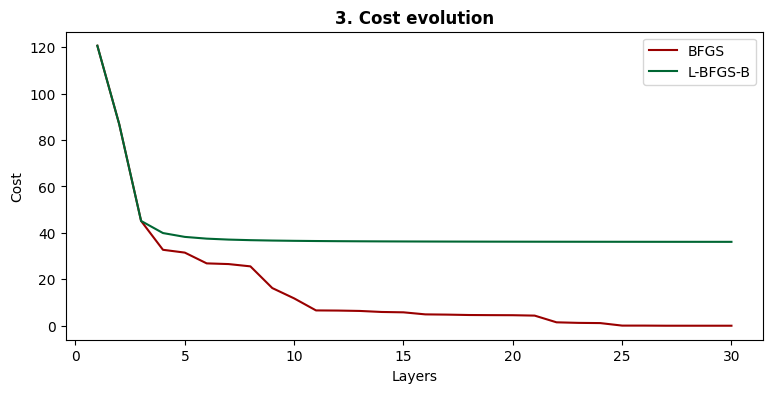

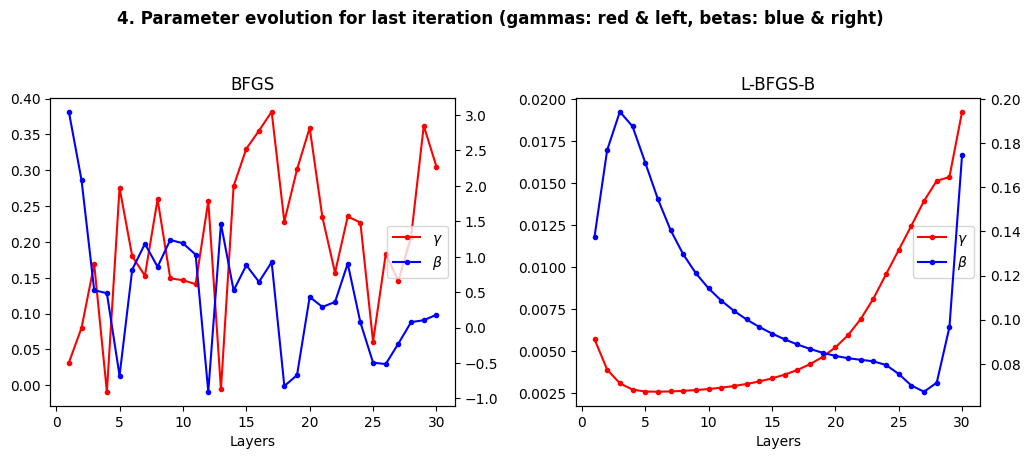

In [75]:
N = 35

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0               gammas  \
1510  39      BFGS       1     0.05     1.5  [0.043914402413695]   
1480  39  L-BFGS-B       1     0.05     1.5  [0.043914402411096]   

                    betas        cost  fidelity  
1510  [1.491486994085921]  185.533424  0.043982  
1480  [1.491486994120301]  185.533424  0.043982

**2. State at layers=30**

N optimizer  layers  gamma_0  beta_0          cost  fidelity
1539  39      BFGS      30     0.05     1.5  4.660267e-08  0.999976
1509  39  L-BFGS-B      30     0.05     1.5  9.067076e+01  0.016777

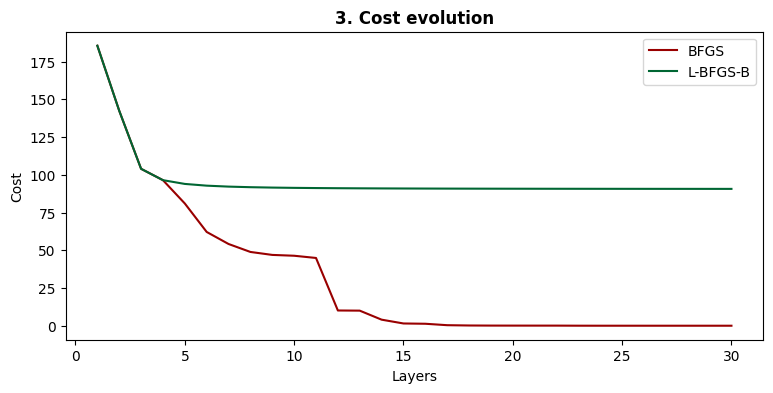

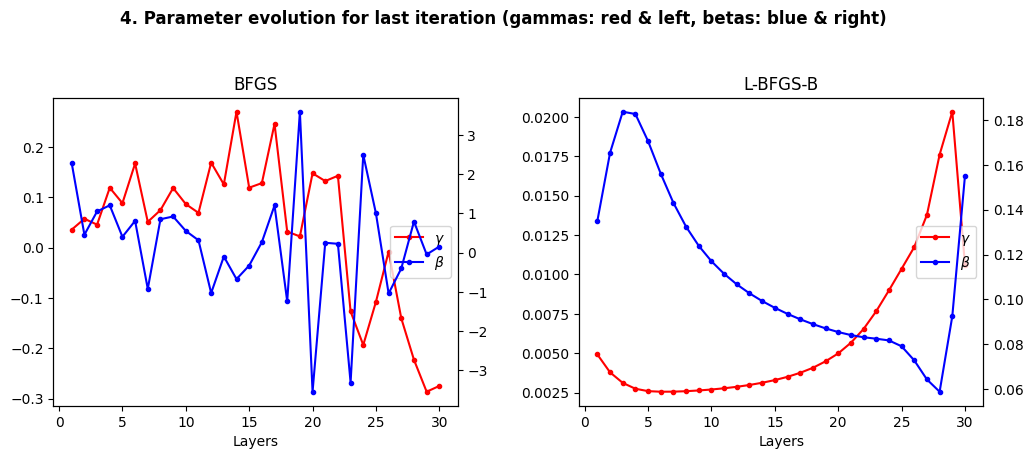

In [76]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = 30 # int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0                  gammas  \
1050  51      BFGS       1     0.01     1.1  [0.013849093690625001]   
1000  51  L-BFGS-B       1     0.01     1.1     [0.013849093798469]   

                    betas        cost  fidelity  
1050  [1.070235368618127]  741.345508  0.012325  
1000   [1.07023534830555]  741.345508  0.012325

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0      cost  fidelity
1099  51      BFGS      50     0.01     1.1  0.006055  0.992734
1049  51  L-BFGS-B      50     0.01     1.1  0.343571  0.941289

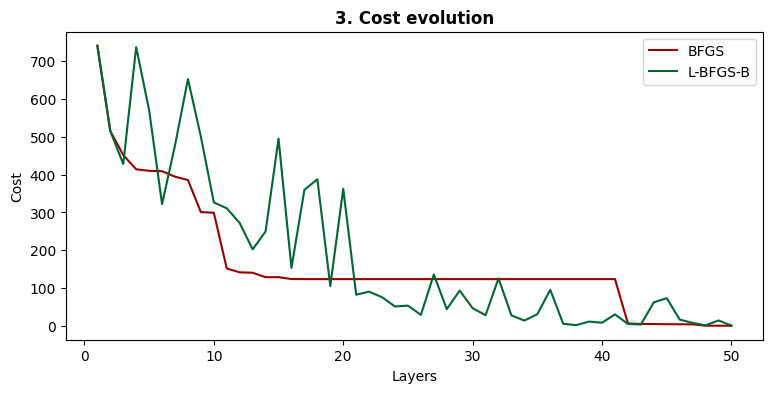

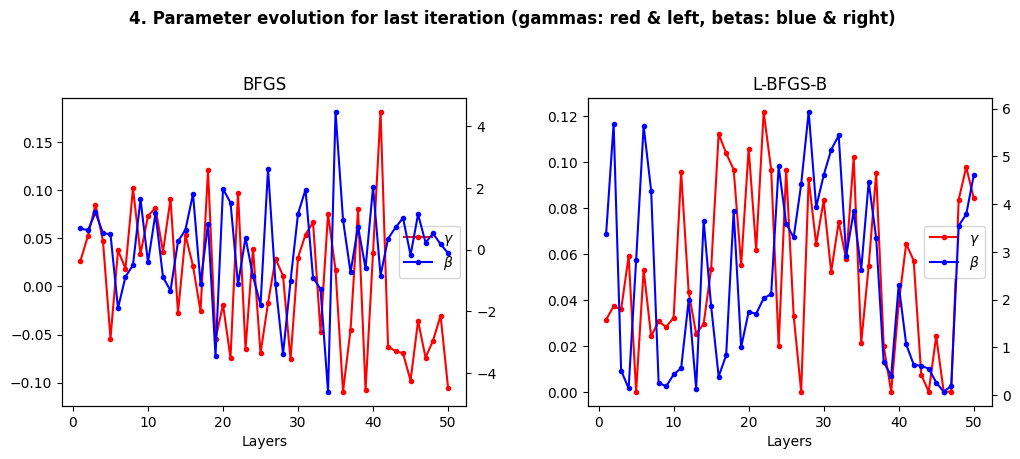

In [77]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0  \
719  77      BFGS      10     0.05     2.3   
669  77  L-BFGS-B      10     0.05     2.3   

                                                gammas  \
719  [0.037195474822034, 0.056795339975508, 0.06703...   
669  [0.082673490883941, 0.052757927992588, 0.03807...   

                                                 betas        cost  fidelity  
719  [1.811560532307027, 0.9970886944208861, -1.454...   33.080414  0.445197  
669  [4.476979597086492, 0.8561116615627371, 1.3254...  324.557794  0.393681

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0      cost  fidelity
759  77      BFGS      50     0.05     2.3  0.006583  0.985991
709  77  L-BFGS-B      50     0.05     2.3  5.270176  0.715756

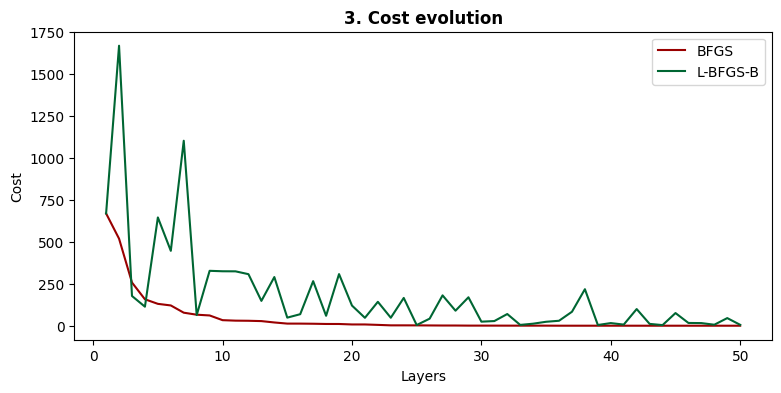

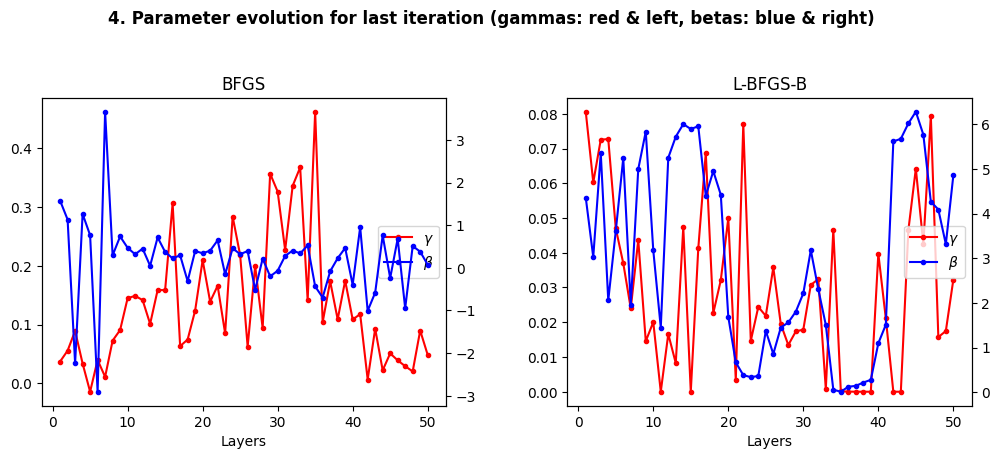

In [78]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==10][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0  \
909  87      BFGS      10     0.02     0.8   
959  87  L-BFGS-B      10     0.02     0.8   

                                                gammas  \
909  [0.018953070715265002, 0.037281134341975004, 0...   
959  [0.0044795533180150005, 0.0, 0.004465539768021...   

                                                 betas        cost  fidelity  
909  [1.017564561284985, -1.061337845102184, -0.664...  841.704165  0.010930  
959  [5.40517470275857, 2.234784878756313, 0.625137...  583.619645  0.000089

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
949  87      BFGS      50     0.02     0.8    3.486856  0.935322
999  87  L-BFGS-B      50     0.02     0.8  284.309881  0.019009

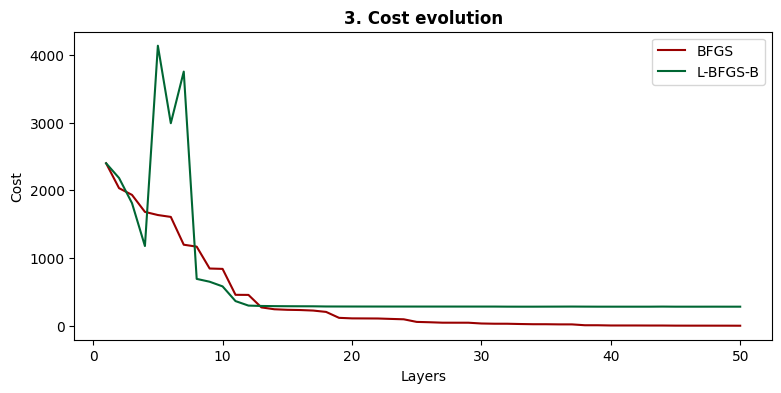

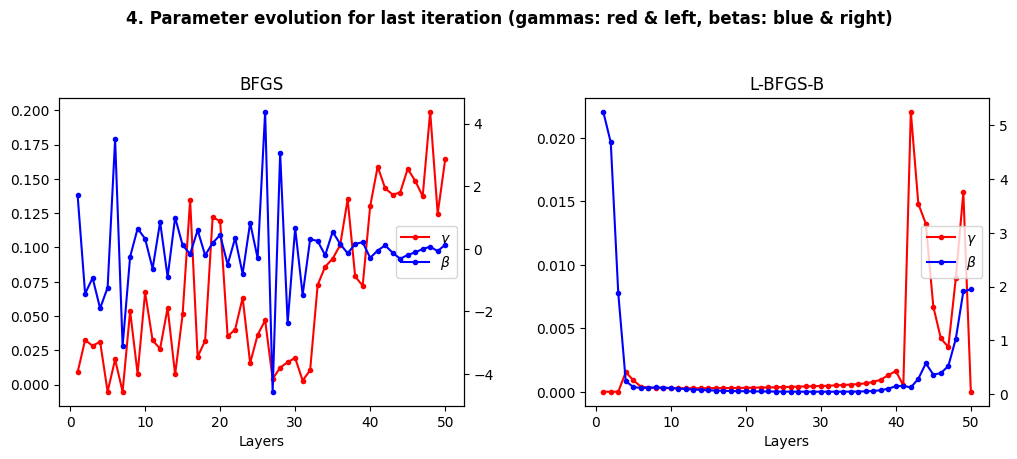

In [79]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==10][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N optimizer  layers  gamma_0  beta_0  \
99  95      BFGS      10     0.02     0.8   
49  95  L-BFGS-B      10     0.02     0.8   

                                               gammas  \
99  [0.025272203254165, 0.028762073183601, 0.01522...   
49  [0.049309798106274005, 0.03477507562485, 0.051...   

                                                betas         cost  fidelity  
99  [0.527339251975785, -0.8621735023147891, -1.28...  1018.308777  0.015728  
49  [4.818070002571228, 2.142727353221166, 1.15267...  2022.904572  0.001096

**2. State at layers=50**

N optimizer  layers  gamma_0  beta_0        cost  fidelity
139  95      BFGS      50     0.02     0.8   34.085251  0.017293
89   95  L-BFGS-B      50     0.02     0.8  250.762606  0.147111

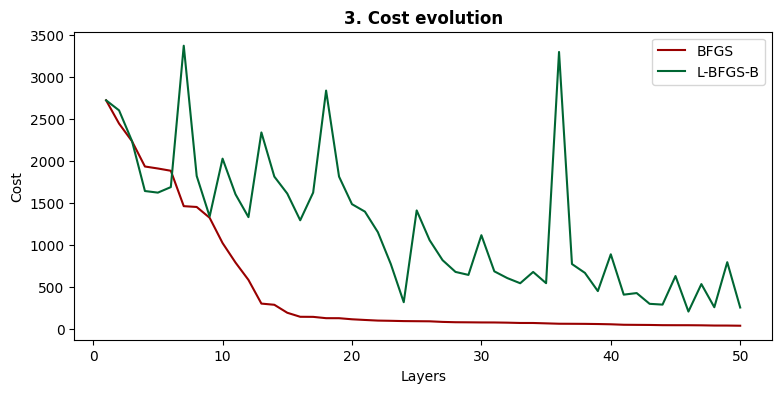

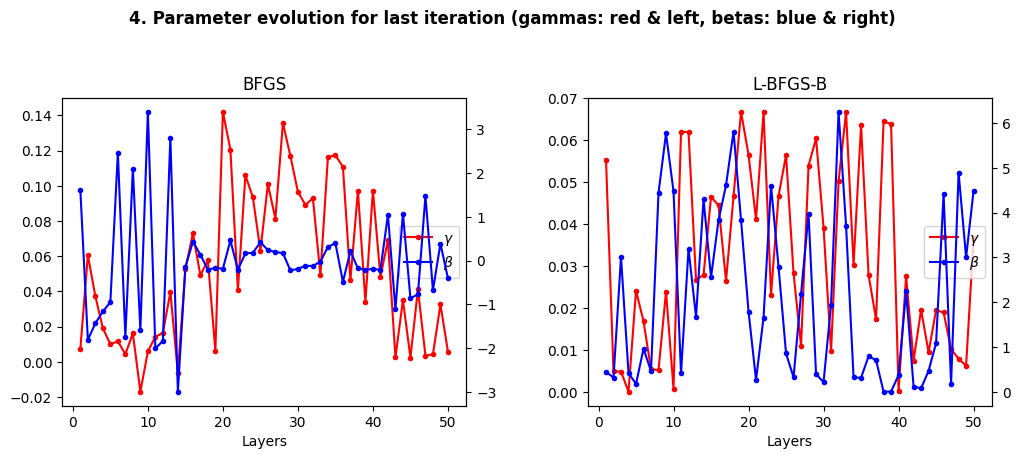

In [80]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='linear_abs')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==10][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('optimizer'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'optimizer', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('optimizer'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=optimizer)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_i = df[df['optimizer']==optimizer]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(optimizer)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Comparison standard (unbounded) vs linear (unbounded)

### N = 21

## N=21

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0               gammas  \
790  21        linear_abs       1    0.150     1.5  [0.150167535914248]   
770  21  linear_quadratic       1    0.150     1.5  [0.154564850965925]   
10   21          standard       1    0.007     1.5  [0.008278311895312]   

                    betas       cost  fidelity  
790  [1.4849625382688751]  46.362263  0.174848  
770  [1.5075920586575662]  74.357584  0.169938  
10    [1.529769538903815]  32.774907  0.757476

**2. State at layers=10**

N             setup  layers  gamma_0  beta_0          cost  fidelity
799  21        linear_abs      10    0.150     1.5  2.466064e-34       1.0
779  21  linear_quadratic      10    0.150     1.5  1.943862e-19       1.0
19   21          standard      10    0.007     1.5  1.346965e-21       1.0

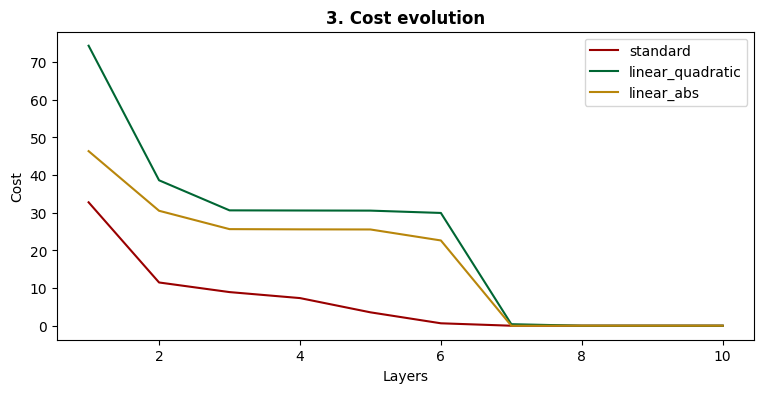

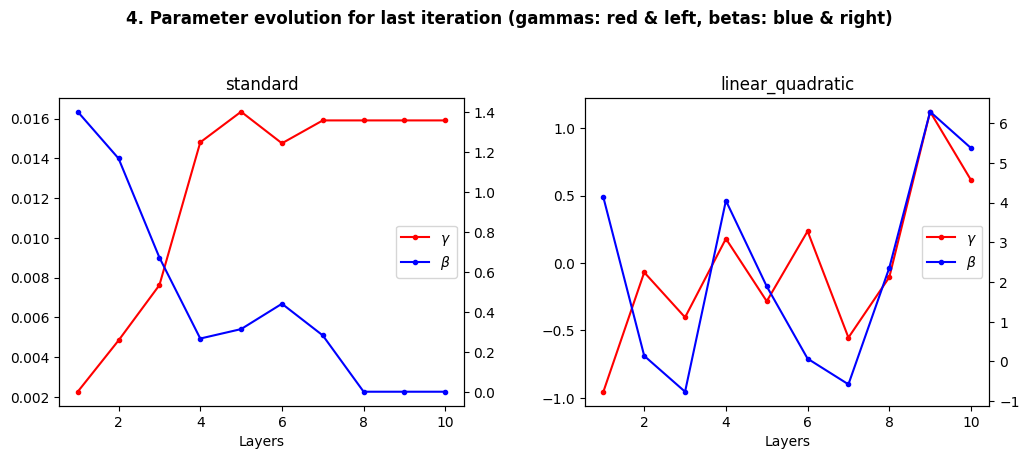

In [81]:
N = 21

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 39

## N=39

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0               gammas  \
1510  39        linear_abs       1   0.0500     1.5  [0.043914402413695]   
200   39  linear_quadratic       1   0.0500     1.5  [0.042419916569209]   
140   39          standard       1   0.0005     0.4  [0.000445775660771]   

                     betas        cost  fidelity  
1510   [1.491486994085921]  185.533424  0.043982  
200     [1.46558428370015]  308.614459  0.046635  
140   [0.5244786704891571]  488.233997  0.045932

**2. State at layers=30**

N             setup  layers  gamma_0  beta_0          cost  fidelity
1539  39        linear_abs      30   0.0500     1.5  4.660267e-08  0.999976
229   39  linear_quadratic      30   0.0500     1.5  4.595719e-03  0.999791
169   39          standard      30   0.0005     0.4  4.445246e-01  0.982655

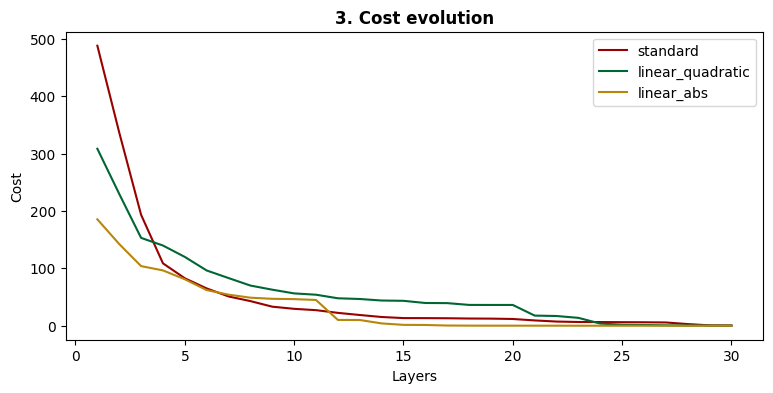

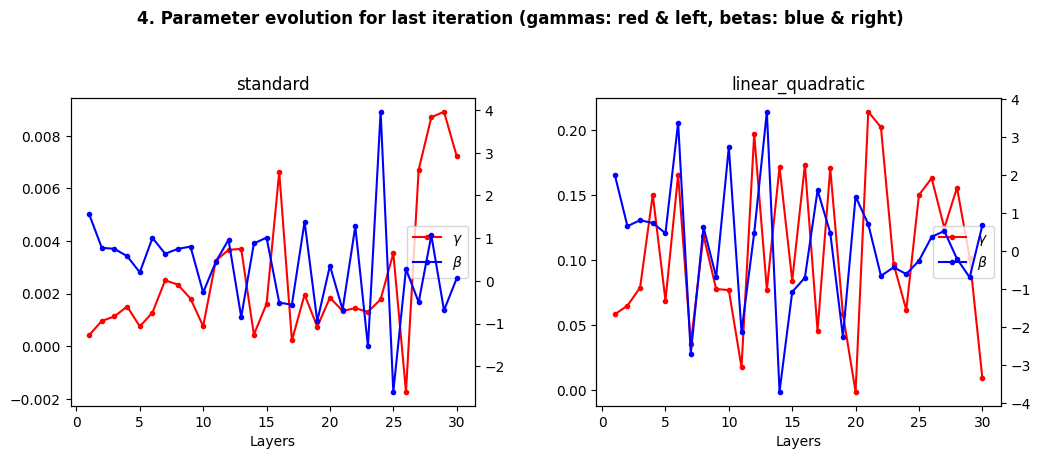

In [82]:
N = 39

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==df['layers'].max()][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 51

## N=51

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                   gammas  \
1050  51        linear_abs       1   0.0100     1.1   [0.013849093690625001]   
800   51  linear_quadratic       1   0.0100     1.1   [0.013172117193072002]   
610   51          standard       1   0.0001     0.8  [7.653187295904522e-05]   

                     betas         cost  fidelity  
1050   [1.070235368618127]   741.345508  0.012325  
800    [1.071317677840412]   957.604456  0.012695  
610   [0.6251993693818071]  1326.671435  0.023830

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0       cost  fidelity
1099  51        linear_abs      50   0.0100     1.1   0.006055  0.992734
849   51  linear_quadratic      50   0.0100     1.1   6.510248  0.008734
659   51          standard      50   0.0001     0.8  14.969879  0.244035

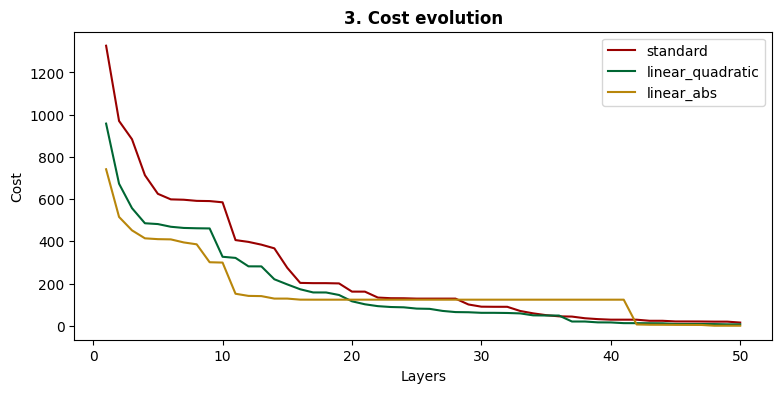

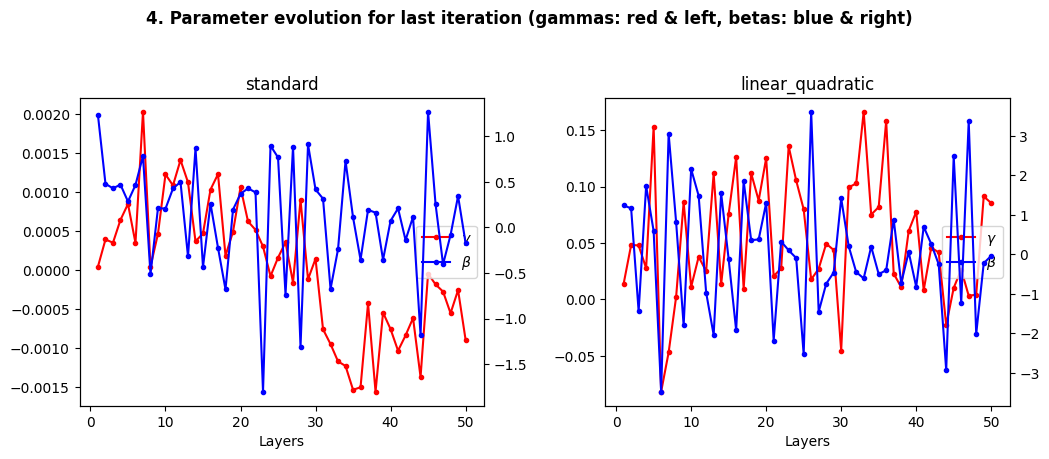

In [87]:
N = 51

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 77

## N=77

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                  gammas  \
710   77        linear_abs       1   0.0500    2.30  [0.049438310407823004]   
360   77  linear_quadratic       1   0.0500    2.30     [0.049794543256928]   
1150  77          standard       1   0.0001    0.39     [0.000108307745618]   

                     betas         cost  fidelity  
710    [2.219804708201128]   669.103878  0.108715  
360    [2.270977840921084]  1382.099774  0.104663  
1150  [0.5230479893037681]  1934.541313  0.022078

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0       cost  fidelity
759   77        linear_abs      50   0.0500    2.30   0.006583  0.985991
409   77  linear_quadratic      50   0.0500    2.30   1.364976  0.934051
1199  77          standard      50   0.0001    0.39  10.891139  0.399982

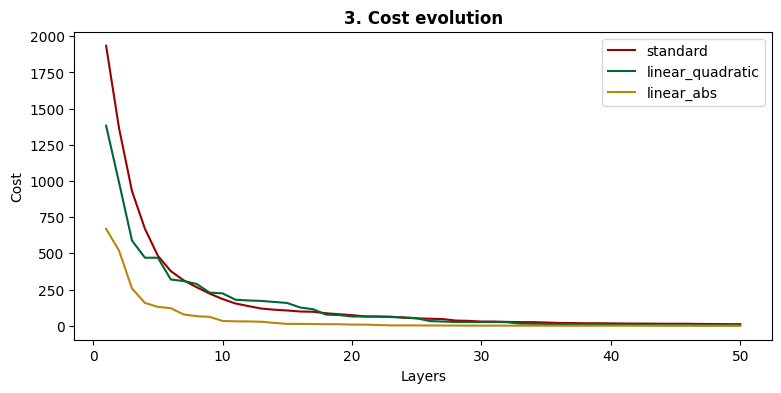

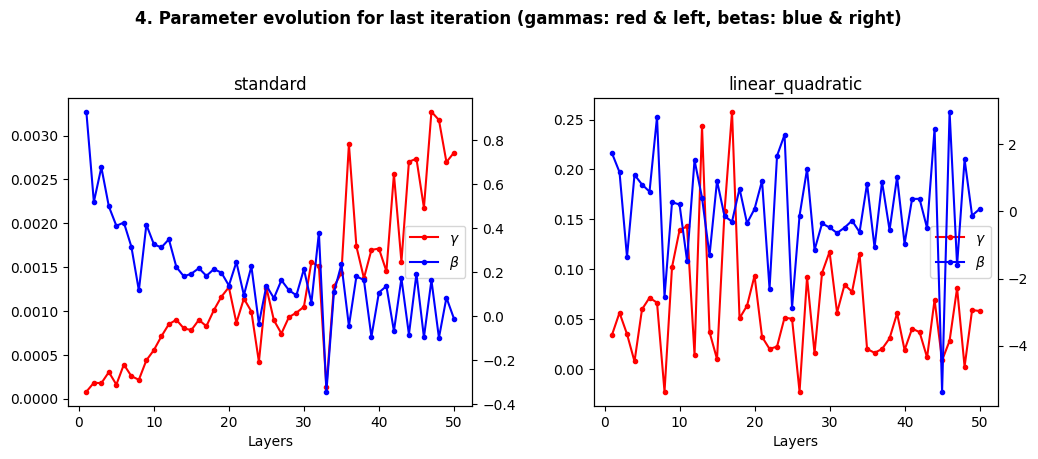

In [88]:
N = 77

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 87

## N=87

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                    gammas  \
900   87        linear_abs       1  0.02000     0.8       [0.021965025355482]   
310   87  linear_quadratic       1  0.02000     0.8    [0.021105579454695003]   
1360  87          standard       1  0.00002     0.8  [1.7797972544527962e-05]   

                     betas         cost  fidelity  
900   [0.8692263792364241]  2399.274198  0.026463  
310    [0.846775704930748]  4595.785424  0.029289  
1360    [0.64937828388257]  5104.575317  0.009896

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0        cost  fidelity
949   87        linear_abs      50  0.02000     0.8    3.486856  0.935322
359   87  linear_quadratic      50  0.02000     0.8  157.346934  0.409059
1409  87          standard      50  0.00002     0.8  190.280669  0.061161

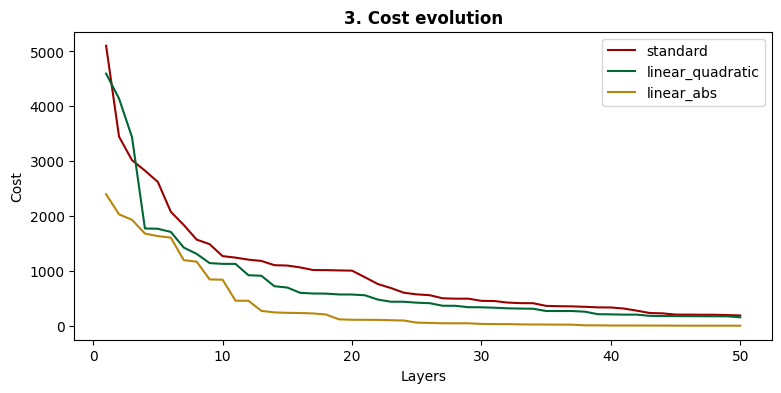

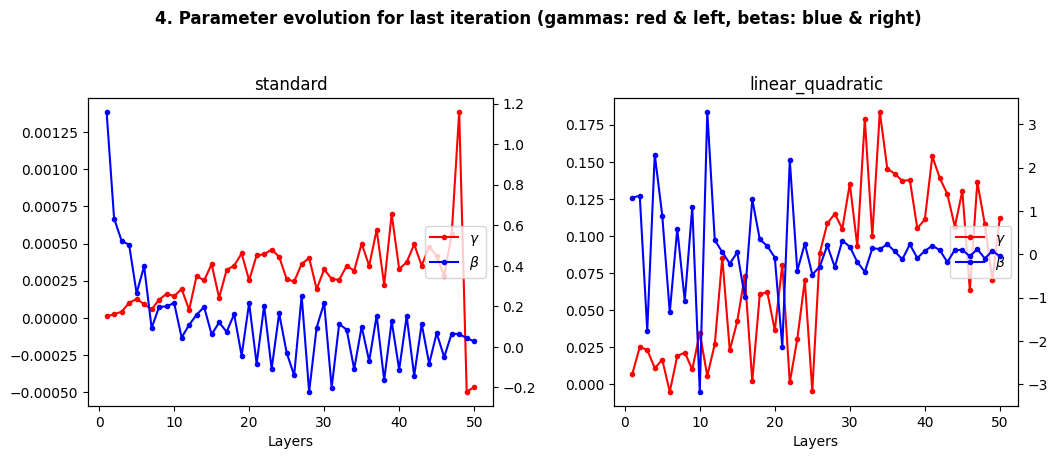

In [89]:
N = 87

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

### N = 95

## N=95

**1. One layer QAOA**

N             setup  layers  gamma_0  beta_0                   gammas  \
90    95        linear_abs       1  0.02000     0.8   [0.021773547329559002]   
1310  95  linear_quadratic       1  0.00002     0.8   [-0.38102473977994206]   
460   95          standard       1  0.00002     0.8  [1.826878524076459e-05]   

                     betas         cost  fidelity  
90    [0.8459275237878101]  2717.386126  0.002085  
1310  [1.6566699747106721]  5862.389439  0.017003  
460   [0.6286191475733971]  5273.884037  0.011792

**2. State at layers=50**

N             setup  layers  gamma_0  beta_0        cost  fidelity
139   95        linear_abs      50  0.02000     0.8   34.085251  0.017293
1359  95  linear_quadratic      50  0.00002     0.8  283.906942  0.027451
509   95          standard      50  0.00002     0.8  117.443747  0.081479

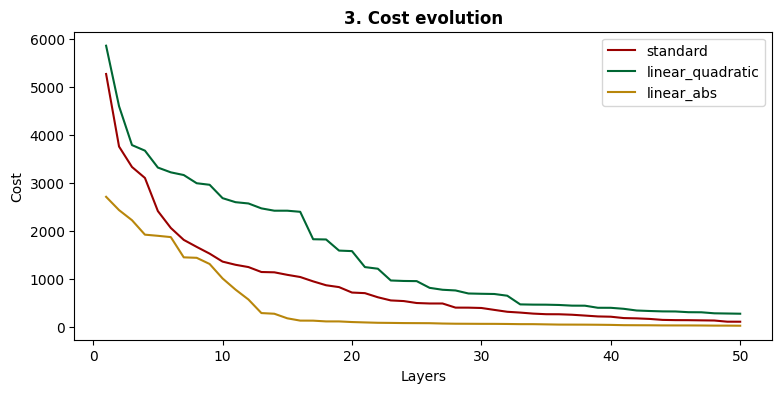

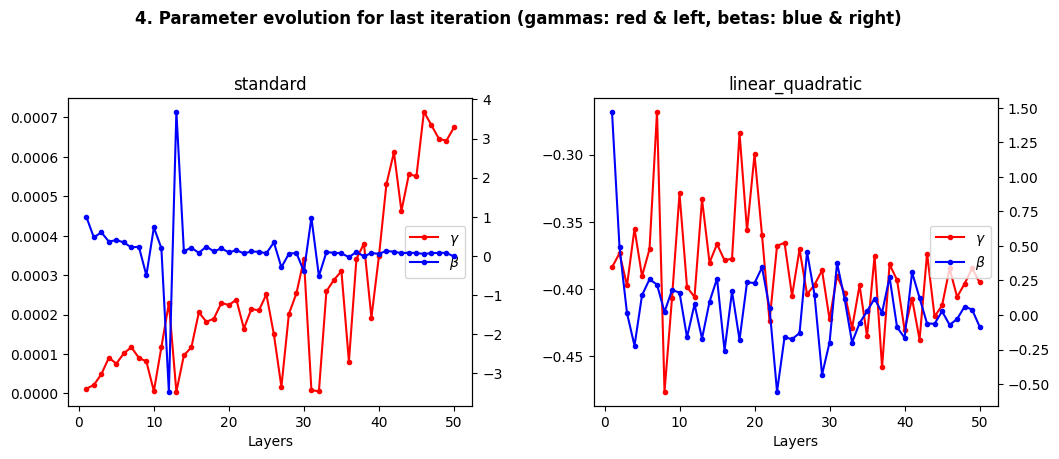

In [90]:
N = 95

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
max_layers = int(df['layers'].max())

display(Markdown(f"## N={N}"))
display(Markdown("**1. One layer QAOA**"))
display(df[df['layers']==1][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('setup'))

display(Markdown(f"**2. State at layers={max_layers}**"))
display(df[df['layers']==max_layers][['N', 'setup', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('setup'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_i = df[df['setup']==setup]
    ax.plot('layers', 'cost', data=df_i, color=plot_colors[i+2][0], label=setup)
ax.set_xlabel('Layers')
ax.set_ylabel('Cost')
ax.legend()
ax.set_title('3. Cost evolution', fontweight='bold')


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)
sec_axs = [ax.twinx() for ax in axs]
for i, setup in enumerate(['standard', 'linear_quadratic']):
    df_i = df[df['setup']==setup]
    max_layer_idx = df_i[df_i['layers']==max_layers]['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red', label='$\\gamma$')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue', label='$\\beta$')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(setup)
    lines, labels = axs[i].get_legend_handles_labels()
    lines2, labels2 = sec_axs[i].get_legend_handles_labels()
    axs[i].legend(lines + lines2, labels + labels2, loc='center right')
fig.suptitle('4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)', fontweight='bold', y=1.1);

## Summary

In [98]:
df = experiment_results[(experiment_results['N'].isin([21,39,51,77,87,95]))]
df = df[df['layers']==df['N'].map({21: 10, 39: 30, 51: 50, 77: 50, 87:50, 95:50})]
df = df[df['optimizer']=='BFGS']
df = df[['N', 'num_qubits', 'setup', 'max_layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']]
df = df.rename(columns={'setup': 'protocol'})
pivot = df.pivot_table(values=['cost', 'fidelity'], index=['N'], columns=['protocol'])
pivot.columns = pivot.columns.reorder_levels(['protocol', None])
pivot = pivot.sort_index(axis=1, level=[0,1], ascending=[False, True])

pivot

protocol      standard           linear_quadratic              linear_abs  \
                  cost  fidelity             cost  fidelity          cost   
N                                                                           
21        1.346965e-21  1.000000     1.943862e-19  1.000000  2.466064e-34   
39        4.445246e-01  0.982655     4.595719e-03  0.999791  4.660267e-08   
51        1.496988e+01  0.244035     6.510248e+00  0.008734  6.054680e-03   
77        1.089114e+01  0.399982     1.364976e+00  0.934051  6.583337e-03   
87        1.902807e+02  0.061161     1.573469e+02  0.409059  3.486856e+00   
95        1.174437e+02  0.081479     2.839069e+02  0.027451  3.408525e+01   

protocol            
          fidelity  
N                   
21        1.000000  
39        0.999976  
51        0.992734  
77        0.985991  
87        0.935322  
95        0.017293

## Extras

### Fidelity plots

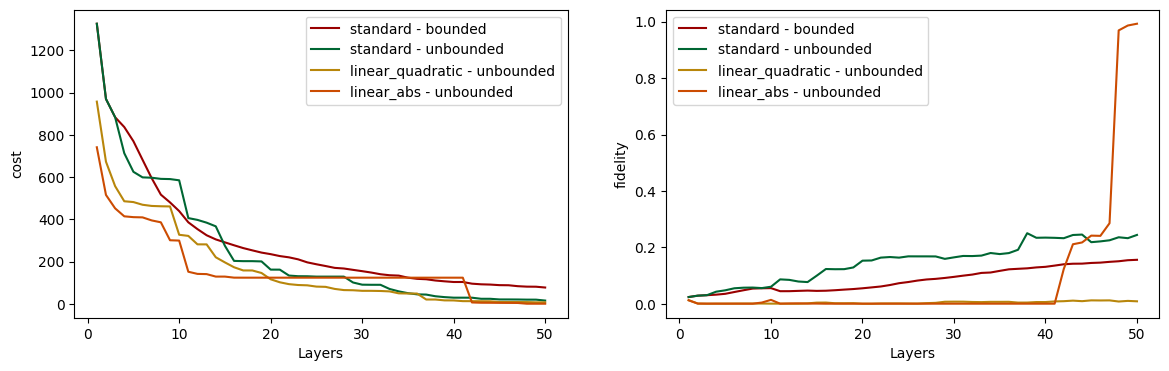

In [46]:
N = 51

df = experiment_results[(experiment_results['N']==N) & (experiment_results['layers']<=50)]

opt_map = {'L-BFGS-B': 'bounded', 'BFGS': 'unbounded'}

fig, axs = plt.subplots(1, 2, figsize=(14, 4))
for j, metric in enumerate(['cost', 'fidelity']):
    for i in range(4):
        if i==0:
            setup = 'standard'
            optimizer = 'L-BFGS-B'
        elif i==1:
            setup = 'standard'
            optimizer = 'BFGS'
        elif i==2:
            setup = 'linear_quadratic'
            optimizer = 'BFGS'
        elif i==3:
            setup = 'linear_abs'
            optimizer = 'BFGS'
        df_i = df[(df['setup']==setup) & (df['optimizer']==optimizer)].copy()
        if i==3:
            df_i['cost'] = df_i['cost'].pow(2)
        axs[j].plot('layers', metric, data=df_i, color=plot_colors[i+2][0], label=f'{setup} - {opt_map[optimizer]}')
    axs[j].set_xlabel('Layers')
    axs[j].set_ylabel(metric)
    axs[j].legend();

### Probability distributions

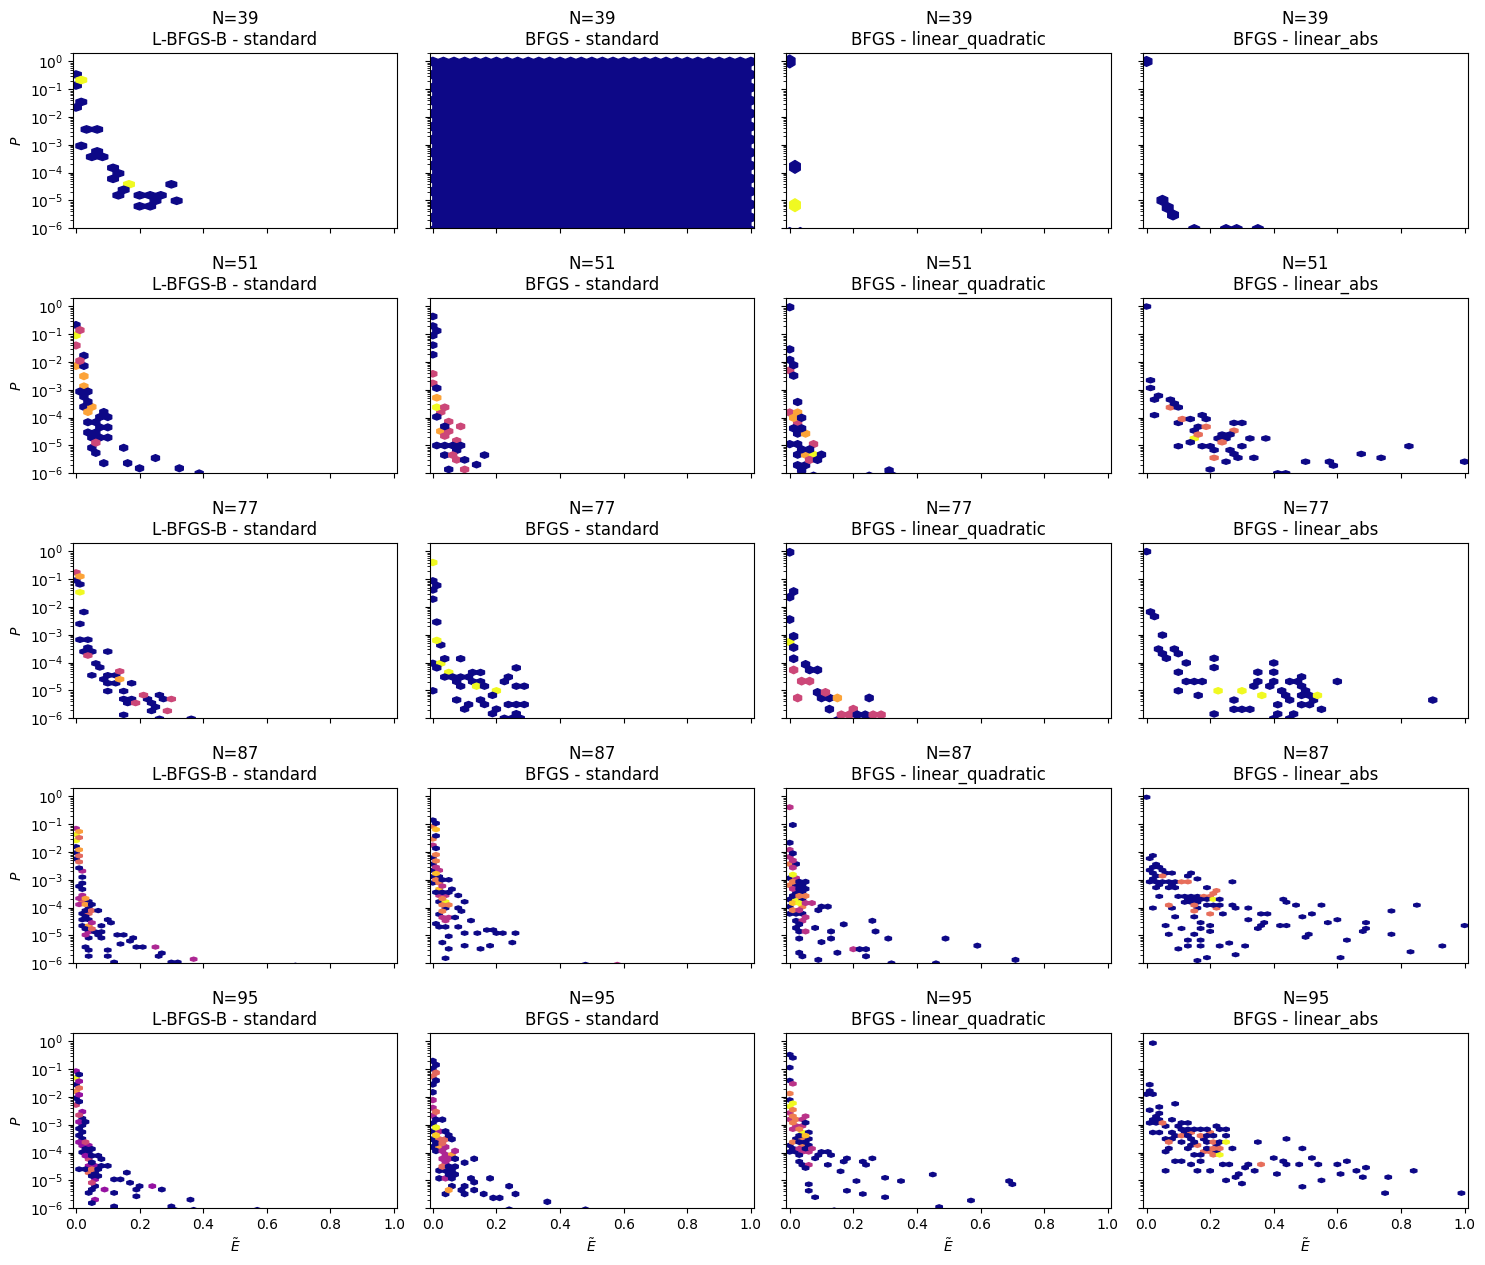

In [47]:
Ns = [39,51,77,87,95]
layers_map = {21: 10, 39: 30, 51: 50, 77: 50, 87:50, 95:50}
gridsize_map = {39: 30, 51: 40, 77:40, 87: 50, 95: 50}

df = experiment_results[(experiment_results['N'].isin(Ns))]
df = df[df['layers']==df['N'].map(layers_map)]

fig, axs = plt.subplots(nrows=len(Ns), ncols=4, figsize=(18,len(Ns)*3), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, N in enumerate(Ns):
    for j in range(4):
        if j==0:
            optimizer = 'L-BFGS-B'
            setup = 'standard'
        elif j==1:
            optimizer = 'BFGS'
            setup = 'standard'
        elif j==2:
            optimizer = 'BFGS'
            setup = 'linear_quadratic'
        elif j==3:
            optimizer = 'BFGS'
            setup = 'linear_abs'
        
        df_s = df[(df['N']==N) & (df['optimizer']==optimizer) & (df['setup']==setup)].reset_index(drop=True)
            
        ax = axs[i][j]

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])
        layer_max = df_s.loc[0, 'layers']

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)
        

        hb = ax.hexbin(rescaled_E, probs, gridsize=gridsize_map[N], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"N={N}\n{optimizer} - {setup}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == len(Ns)-1:
            ax.set_xlabel('$\\tilde{E}$')

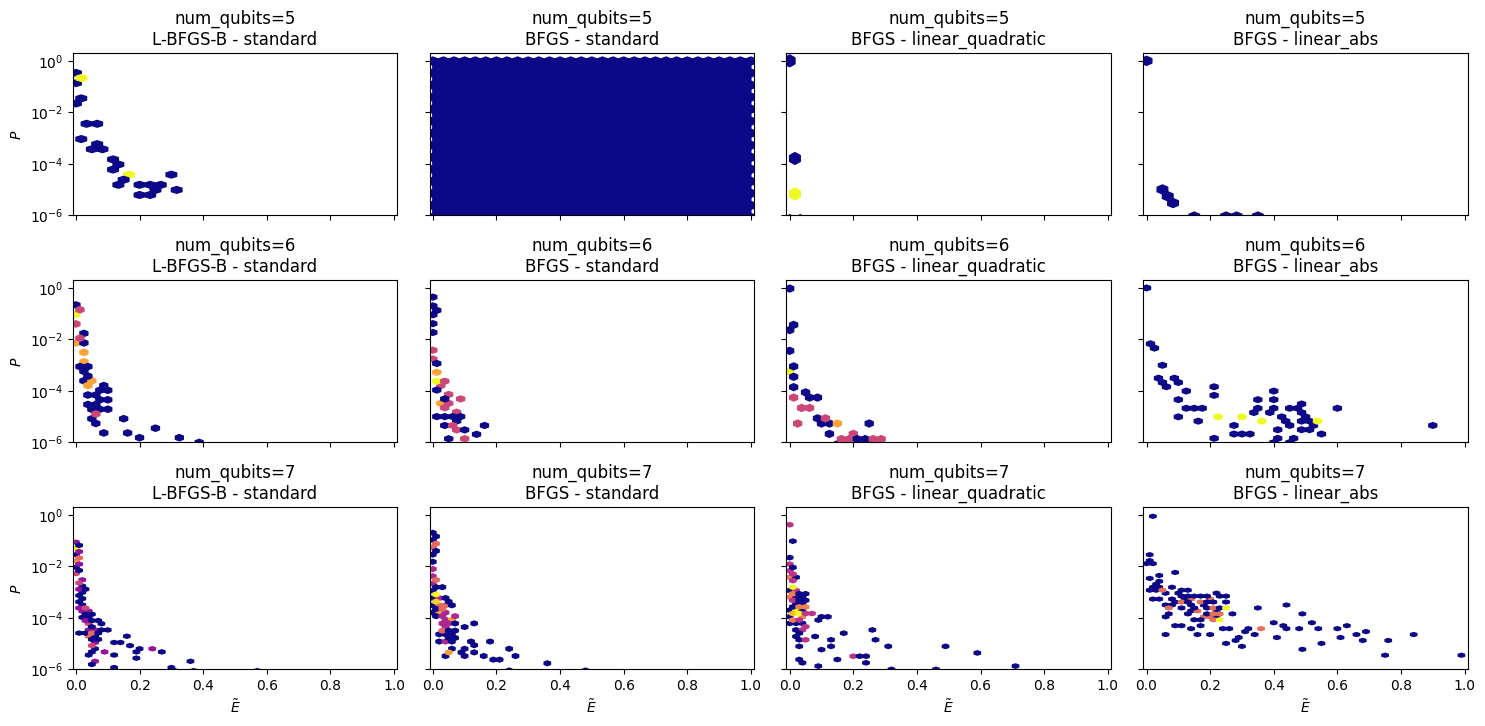

In [48]:
Ns = [39,51,77,87,95]
layers_map = {21: 10, 39: 30, 51: 50, 77: 50, 87:50, 95:50}
gridsize_map = {5: 30, 6: 40, 7: 50}

df = experiment_results[(experiment_results['N'].isin(Ns))]
df = df[df['layers']==df['N'].map(layers_map)]

ns = sorted(df['num_qubits'].unique())

fig, axs = plt.subplots(nrows=len(ns), ncols=4, figsize=(18,8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.1)

for i, n in enumerate(ns):
    for j in range(4):
        if j==0:
            optimizer = 'L-BFGS-B'
            setup = 'standard'
        elif j==1:
            optimizer = 'BFGS'
            setup = 'standard'
        elif j==2:
            optimizer = 'BFGS'
            setup = 'linear_quadratic'
        elif j==3:
            optimizer = 'BFGS'
            setup = 'linear_abs'
        
        df_s = df[(df['num_qubits']==n) & (df['optimizer']==optimizer) & (df['setup']==setup)].reset_index(drop=True)
            
        ax = axs[i][j]

        probs = df_s.loc[0,'state_populations']
        energies = np.array(df_s.loc[0,'Ec'])
        layer_max = df_s.loc[0, 'layers']

        E_min = np.min(energies)
        E_max = np.max(energies)
        rescaled_E = (energies - E_min) / (E_max - E_min)
        

        hb = ax.hexbin(rescaled_E, probs, gridsize=gridsize_map[n], cmap='plasma', bins='log', yscale='log')
        ax.set_title(f"num_qubits={n}\n{optimizer} - {setup}")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(1e-6,2)
        if j == 0:
            ax.set_ylabel('$P$')
        if i == 2:
            ax.set_xlabel('$\\tilde{E}$')

### Cost of abs vs quadratic Hamiltonian

In [32]:
psi = experiment_results[(experiment_results['N']==51)
                         & (experiment_results['setup']=='linear_quadratic')
                         & (experiment_results['layers']==10)
                         & (experiment_results['optimizer']=='BFGS')] \
            .reset_index().loc[0,'state']

psi = np.array([complex(c) for c in psi])

In [44]:
quad_solver = QAOASolver(N=51)
quad_energies = quad_solver.Ec
quad_H = quad_solver.Hc

abs_solver = QAOASolver(N=51, cost_hamiltonian='abs_H')
abs_energies = abs_solver.Ec
abs_H = abs_solver.Hc

In [57]:
np.vdot(psi, quad_H @ psi)

np.complex128(326.6996600852781+3.552713678800501e-15j)

In [53]:
np.vdot(psi, abs_H @ psi)

np.complex128(14.796344602056072+0j)

In [55]:
14.796344602**2

218.93181358113452

In [15]:
abs_energies

array([ 50.,  34.,  42.,  26.,  46.,  30.,  38.,  22.,  48.,  32.,  40.,
        24.,  44.,  28.,  36.,  20.,  46.,  34.,   6.,  74.,  26.,  54.,
        14.,  94.,  36.,  44.,   4.,  84.,  16.,  64.,  24., 104.,  48.,
         0.,  24.,  24.,  36.,  12.,  12.,  36.,  42.,   6.,  18.,  30.,
        30.,  18.,   6.,  42.,  44.,  68.,  12., 124.,  16.,  96.,  40.,
       152.,  30.,  82.,  26., 138.,   2., 110.,  54., 166.])

In [12]:
sum(quad_energies)

np.float64(206976.0)

In [16]:
sum(abs_energies**2)

np.float64(206976.0)

### Others

In [ ]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)

num_qubits = df.loc[0, 'num_qubits']
solutions = compute_solution(N)
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

pops_50 =  df[df['layers']==50].reset_index().loc[0, 'state_populations']
pops_100 =  df[df['layers']==100].reset_index().loc[0, 'state_populations']

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].bar(x_hist, pops_50, color=bar_colors)
axs[1].bar(x_hist, pops_100, color=bar_colors)
axs[0].set_ylabel('Prob')
axs[0].set_xlabel('Computational basis')
axs[1].set_xlabel('Computational basis')

axs[0].set_xticks(range(2**num_qubits), "")
axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].set_title('p = 50')
axs[1].set_xticks(range(2**num_qubits), "")
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].set_title('p = 100');

KeyError: 0

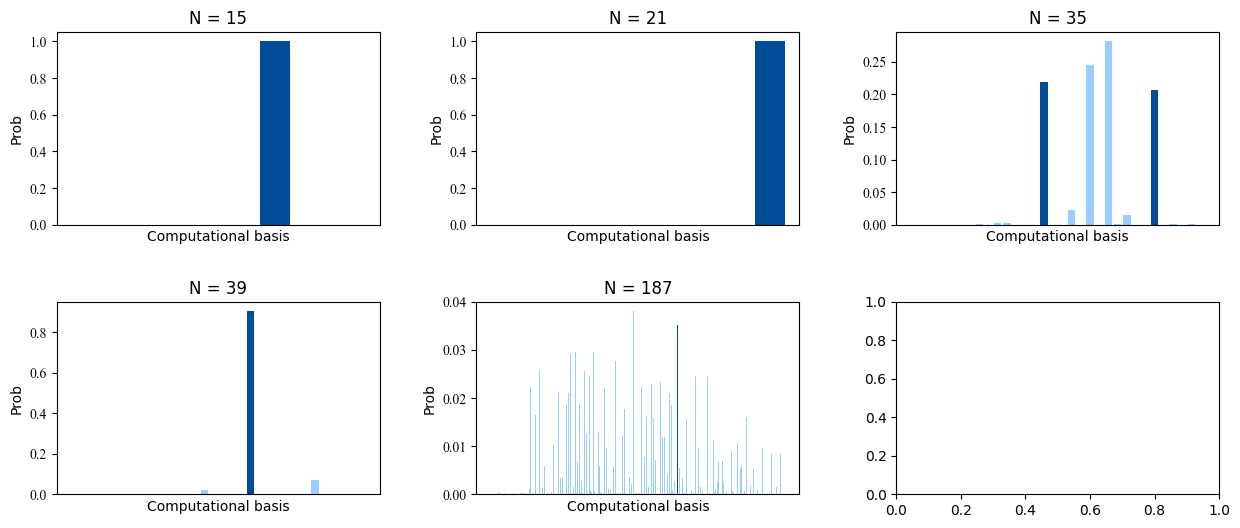

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

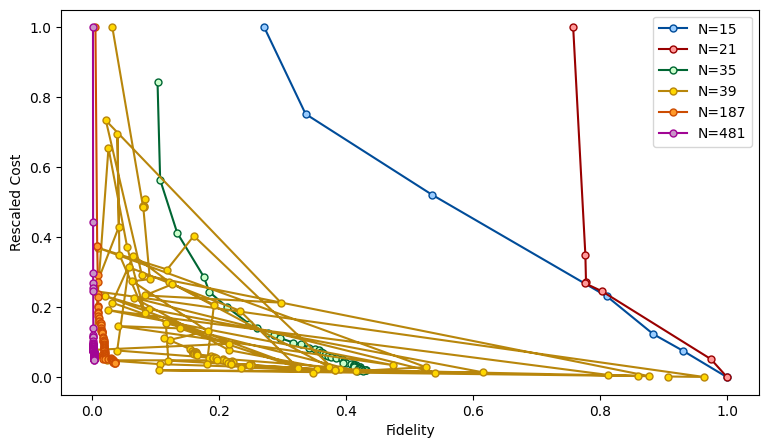

In [ ]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

# plt.savefig('../report_1/img/cost_fidelity.pdf')